# Investigating and Visualizing Subjective Well-Being Around the World

The aim of this project is to explore and gain insight into a dataset with the help of visualizations and other techniques of exploratory data analysis. For this purpose, a dataset was selected that contains data on subjective well-being (SWB) from various countries around the world. This dataset is also used in the World Happiness Report (Helliwell et al., 2022a) to predict SWB based on other variables and to examine regional differences. With the help of different visualizations, the different regions of the world are compared with each other in terms of their SWB and relationships of SWB with the life expectancy are examined. Because current values that have not been affected by the coronavirus pandemic are of interest, the data from 2019 is used. 

## List of Abbreviations
| Abbreviation | Meaning |
|---|---|
| ANZ | Australia and New Zealand |
| IQR | Interquartile range |
| MAD | Median absolute deviation from the median |
| QCD | Quartile coefficient of dispersion |
| SWB | Subjective well-being | 
| UNSD | United Nations Statistics Division |

## Imports

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import wquantiles
import scipy as sp
from sklearn.impute import KNNImputer
from sklearn.covariance import MinCovDet
import pingouin as pg

import pycountry_convert as pc
import textwrap
import string 

# display all rows and columns of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# set seaborn theme 
custom = {"axes.edgecolor": "white", "grid.linestyle": "dashed"}
sns.set_theme(style="whitegrid", font_scale=0.8, rc=custom)

# suppress scientific notation
pd.options.display.float_format = '{:.3f}'.format  # displays three decimals

# hide user warnings
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

Before the data is visualized and techniques of exploratory data analysis are applied, the data is first pre-processed. This involves enriching it with relevant information, identifying and eliminating missing values and filtering the dataset according to the variables of interest. 

In [2]:
# load data
df_happy = pd.read_excel("happiness.xlsx")  # source: Helliwell et al. (2022b), converted to excel, and renamed to "happiness.xlsx"
df_happy.head(15)

Country name  year  Life Ladder  Log GDP per capita  Social support  \
0   Afghanistan  2008        3.724               7.303           0.451   
1   Afghanistan  2009        4.402               7.472           0.552   
2   Afghanistan  2010        4.758               7.579           0.539   
3   Afghanistan  2011        3.832               7.552           0.521   
4   Afghanistan  2012        3.783               7.638           0.521   
5   Afghanistan  2013        3.572               7.658           0.484   
6   Afghanistan  2014        3.131               7.651           0.526   
7   Afghanistan  2015        3.983               7.634           0.529   
8   Afghanistan  2016        4.220               7.629           0.559   
9   Afghanistan  2017        2.662               7.630           0.491   
10  Afghanistan  2018        2.694               7.618           0.508   
11  Afghanistan  2019        2.375               7.633           0.420   
12  Afghanistan  2021        2.436                 NaN           0.454   
13      Albania  2007        4.634               9.122           0.821   
14      Albania  2009        5.485               9.241           0.833   

    Healthy life expectancy at birth  Freedom to make life choices  \
0                             50.500                         0.718   
1                             50.800                         0.679   
2                             51.100                         0.600   
3                             51.400                         0.496   
4                             51.700                         0.531   
5                             52.000                         0.578   
6                             52.300                         0.509   
7                             52.600                         0.389   
8                             52.925                         0.523   
9                             53.250                         0.427   
10                            53.575                         0.374   
11                            53.900                         0.394   
12                            54.550                         0.394   
13                            66.760                         0.529   
14                            67.320                         0.525   

    Generosity  Perceptions of corruption  Positive affect  Negative affect  \
0        0.173                      0.882            0.414            0.258   
1        0.195                      0.850            0.481            0.237   
2        0.126                      0.707            0.517            0.275   
3        0.168                      0.731            0.480            0.267   
4        0.241                      0.776            0.614            0.268   
5        0.066                      0.823            0.547            0.273   
6        0.109                      0.871            0.492            0.375   
7        0.085                      0.881            0.491            0.339   
8        0.047                      0.793            0.501            0.348   
9       -0.116                      0.954            0.435            0.371   
10      -0.088                      0.928            0.385            0.405   
11      -0.103                      0.924            0.324            0.502   
12         NaN                      0.946            0.179            0.607   
13      -0.009                      0.875            0.489            0.246   
14      -0.157                      0.864            0.564            0.279   

    Confidence in national government  
0                               0.612  
1                               0.612  
2                               0.299  
3                               0.307  
4                               0.435  
5                               0.483  
6                               0.409  
7                               0.261  
8                               0.325  
9                               

In [3]:
# display some basic information about the dataset
df_happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country name                       2089 non-null   object 
 1   year                               2089 non-null   int64  
 2   Life Ladder                        2089 non-null   float64
 3   Log GDP per capita                 2062 non-null   float64
 4   Social support                     2076 non-null   float64
 5   Healthy life expectancy at birth   2031 non-null   float64
 6   Freedom to make life choices       2057 non-null   float64
 7   Generosity                         2009 non-null   float64
 8   Perceptions of corruption          1976 non-null   float64
 9   Positive affect                    2065 non-null   float64
 10  Negative affect                    2073 non-null   float64
 11  Confidence in national government  1873 non-null   float

Observations
* The dataset contains missing values.
* Continental and regional information is not included in the dataset.

### Adding Information to the Dataset

In the following, the datasets are enriched by the continents, country codes and regions associated with the countries.
The geographical regions defined by the United Nations Statistics Division (UNSD, 2023) were used to assign the countries to the regions. 
Five countries (Kosovo, Laos, North Cyprus, Somaliland region, Taiwan Province of China) for which SWB data were available were not included in the UNSD breakdown. These five countries were assigned to the same regions as their neighboring countries. The names of the countries were adapted to the names used in the World Happiness Report. 
As in the World Happiness Report, Australia and New Zealand (ANZ) were added to North America in order to increase the number of countries in this region from 2 to 4 and to maintain comparability with the World Happiness Report as much as possible. The allocation in the World Happiness Report was not adopted because it was not specified exactly how the countries were allocated to regions.

In [4]:
# add the continent corresponding to the country and the country's ISO-3166-1 alpha 2 code to the dataset
def get_a2_and_continent(country):
    """retrieve the country's ISO-3166-1 alpha 2 codes and the continent corresponding to the country
    """
    country_a2 = pc.country_name_to_country_alpha2(country)
    continent_code = pc.country_alpha2_to_continent_code(country_a2)
    continent_name = pc.convert_continent_code_to_continent_name(continent_code)
    return country_a2, continent_name

# standardize country naming
# these are the countries that are named differently in the pycountry module
country_dict = {'Congo (Brazzaville)': 'Congo', 'Congo (Kinshasa)': 'Congo', 'Hong Kong S.A.R. of China': 'Hong Kong', 
                'North Cyprus': 'Cyprus', 'Palestinian Territories': 'Palestine', 'Somaliland region': 'Somalia',
                'Taiwan Province of China': 'Taiwan'}
continent = []
code = []  
all_countries = df_happy['Country name'].tolist()
for country in all_countries:
    if country in country_dict.keys():
        country = country_dict[country]
    if country == 'Kosovo':
        continent.append('Europe')
        code.append("XK")
        continue
    a2_code, cont = get_a2_and_continent(country)
    code.append(a2_code)
    continent.append(cont)

df_happy.insert(1, 'Continent', continent)
df_happy.insert(2, "Country code", code)

# merge North and South America into America
df_happy = df_happy.replace(["South America", "North America"], "America")
df_happy.head(15)

Country name Continent Country code  year  Life Ladder  Log GDP per capita  \
0   Afghanistan      Asia           AF  2008        3.724               7.303   
1   Afghanistan      Asia           AF  2009        4.402               7.472   
2   Afghanistan      Asia           AF  2010        4.758               7.579   
3   Afghanistan      Asia           AF  2011        3.832               7.552   
4   Afghanistan      Asia           AF  2012        3.783               7.638   
5   Afghanistan      Asia           AF  2013        3.572               7.658   
6   Afghanistan      Asia           AF  2014        3.131               7.651   
7   Afghanistan      Asia           AF  2015        3.983               7.634   
8   Afghanistan      Asia           AF  2016        4.220               7.629   
9   Afghanistan      Asia           AF  2017        2.662               7.630   
10  Afghanistan      Asia           AF  2018        2.694               7.618   
11  Afghanistan      Asia           AF  2019        2.375               7.633   
12  Afghanistan      Asia           AF  2021        2.436                 NaN   
13      Albania    Europe           AL  2007        4.634               9.122   
14      Albania    Europe           AL  2009        5.485               9.241   

    Social support  Healthy life expectancy at birth  \
0            0.451                            50.500   
1            0.552                            50.800   
2            0.539                            51.100   
3            0.521                            51.400   
4            0.521                            51.700   
5            0.484                            52.000   
6            0.526                            52.300   
7            0.529                            52.600   
8            0.559                            52.925   
9            0.491                            53.250   
10           0.508                            53.575   
11           0.420                            53.900   
12           0.454                            54.550   
13           0.821                            66.760   
14           0.833                            67.320   

    Freedom to make life choices  Generosity  Perceptions of corruption  \
0                          0.718       0.173                      0.882   
1                          0.679       0.195                      0.850   
2                          0.600       0.126                      0.707   
3                          0.496       0.168                      0.731   
4                          0.531       0.241                      0.776   
5                          0.578       0.066                      0.823   
6                          0.509       0.109                      0.871   
7                          0.389       0.085                      0.881   
8                          0.523       0.047                      0.793   
9                          0.427      -0.116                      0.954   
10                         0.374      -0.088                      0.928   
11                         0.394      -0.103                      0.924   
12                         0.394         NaN                      0.946   
13                         0.529      -0.009                      0.875   
14                         0.525      -0.157                      0.864   

    Positive affect  Negative affect  Confidence in national government  
0             0.414            0.258                              0.612  
1             0.481            0.237                              0.612  
2             0.517            0.275                              0.299  
3             0.480            0.267                              0.307  
4             0.614            0.268                              0.435  
5             0.547            0.273                              0.483  
6             0.492            0.375                              0.409  
7             0.

In [5]:
# add regional information to the dataset
df_reg = pd.read_excel("unsd_regions.xlsx")  # source: UNSD (2023). The xlsx file was created based on the specifications.

dict_reg = dict(zip(df_reg["Country"], df_reg["Region"]))
reg = [dict_reg[country] for country in all_countries]
df_happy.insert(2, "Region", reg)
df_happy.head(30)

Country name Continent           Region Country code  year  Life Ladder  \
0   Afghanistan      Asia    Southern Asia           AF  2008        3.724   
1   Afghanistan      Asia    Southern Asia           AF  2009        4.402   
2   Afghanistan      Asia    Southern Asia           AF  2010        4.758   
3   Afghanistan      Asia    Southern Asia           AF  2011        3.832   
4   Afghanistan      Asia    Southern Asia           AF  2012        3.783   
5   Afghanistan      Asia    Southern Asia           AF  2013        3.572   
6   Afghanistan      Asia    Southern Asia           AF  2014        3.131   
7   Afghanistan      Asia    Southern Asia           AF  2015        3.983   
8   Afghanistan      Asia    Southern Asia           AF  2016        4.220   
9   Afghanistan      Asia    Southern Asia           AF  2017        2.662   
10  Afghanistan      Asia    Southern Asia           AF  2018        2.694   
11  Afghanistan      Asia    Southern Asia           AF  2019        2.375   
12  Afghanistan      Asia    Southern Asia           AF  2021        2.436   
13      Albania    Europe  Southern Europe           AL  2007        4.634   
14      Albania    Europe  Southern Europe           AL  2009        5.485   
15      Albania    Europe  Southern Europe           AL  2010        5.269   
16      Albania    Europe  Southern Europe           AL  2011        5.867   
17      Albania    Europe  Southern Europe           AL  2012        5.510   
18      Albania    Europe  Southern Europe           AL  2013        4.551   
19      Albania    Europe  Southern Europe           AL  2014        4.814   
20      Albania    Europe  Southern Europe           AL  2015        4.607   
21      Albania    Europe  Southern Europe           AL  2016        4.511   
22      Albania    Europe  Southern Europe           AL  2017        4.640   
23      Albania    Europe  Southern Europe           AL  2018        5.004   
24      Albania    Europe  Southern Europe           AL  2019        4.995   
25      Albania    Europe  Southern Europe           AL  2020        5.365   
26      Albania    Europe  Southern Europe           AL  2021        5.255   
27      Algeria    Africa  Northern Africa           DZ  2010        5.464   
28      Algeria    Africa  Northern Africa           DZ  2011        5.317   
29      Algeria    Africa  Northern Africa           DZ  2012        5.605   

    Log GDP per capita  Social support  Healthy life expectancy at birth  \
0                7.303           0.451                            50.500   
1                7.472           0.552                            50.800   
2                7.579           0.539                            51.100   
3                7.552           0.521                            51.400   
4                7.638           0.521                            51.700   
5                7.658           0.484                            52.000   
6                7.651           0.526                            52.300   
7                7.634           0.529                            52.600   
8                7.629           0.559                            52.925   
9                7.630           0.491                            53.250   
10               7.618           0.508                            53.575   
11               7.633           0.420                            53.900   
12                 NaN           0.454                            54.550   
13               9.122           0.821                            66.760   
14               9.241           0.833                            67.320   
15               9.283           0.733                            67.600   
16               9.310           0.759                            67.880   
17               9.326           0.785                            68.160   
18               9.338           0.759                            68.440   
19               9.358           0.626                          

### Missing Values

The following section takes a closer look at missing values. An investigation is made into whether certain rows have a particularly high number of missing values. It is also explored whether there are continental differences in the occurrence of missing values.

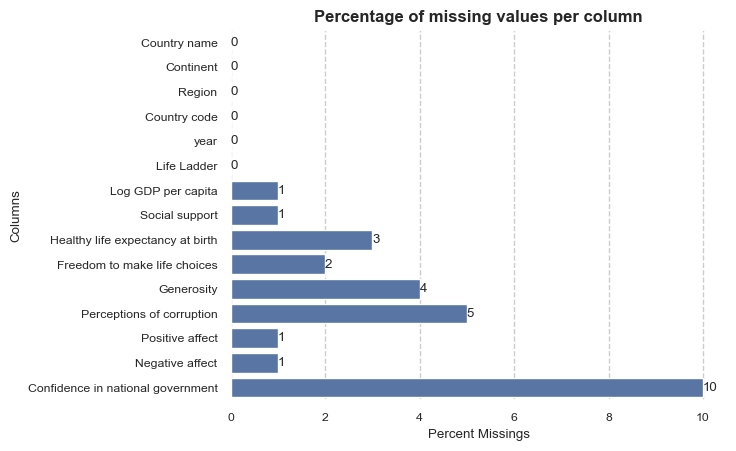

In [6]:
# display the number of missing values per column as percentages
# get the number of missing values per column
missings = [df_happy[col].isnull().sum() for col in df_happy.columns]

# calculate percentages
missings_percent = [round((val/df_happy.shape[0])*100) for val in missings]

# visualize percentages of missing values
data_perc = {'Columns': df_happy.columns, 'Percent Missings': missings_percent}
df_miss_perc = pd.DataFrame(data_perc)
ax1 = sns.barplot(df_miss_perc, x="Percent Missings", y="Columns")
ax1.bar_label(ax1.containers[0])
plt.title("Percentage of missing values per column", size=12, fontweight="bold")
plt.show()

Observations
* There are no missing values for five variables, including the primary variable of interest.
* No variable has more than 10% missing values.
* Only one variable has more than 5% missing values.

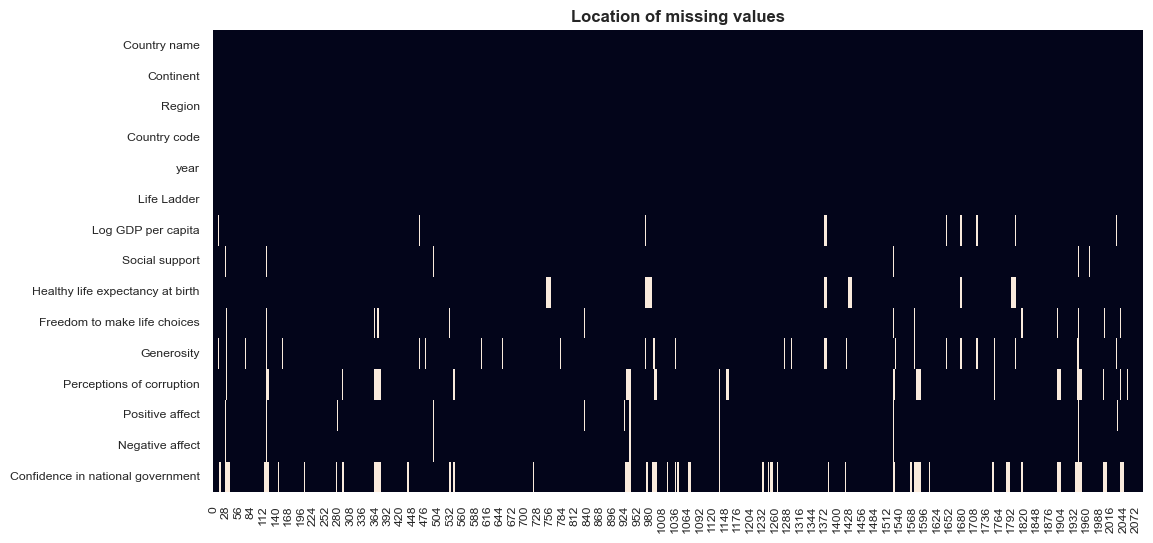

In [7]:
# do certain rows have a particularly high number of missing values?
plt.figure(figsize=(12, 6))
sns.heatmap(df_happy.isnull().transpose(), cbar=False)
plt.title("Location of missing values", size=12, fontweight="bold")
plt.show()

Observations
* It does not seem as if certain rows have a particularly high number of missing values.
* There is no real recognizable pattern in missing values.

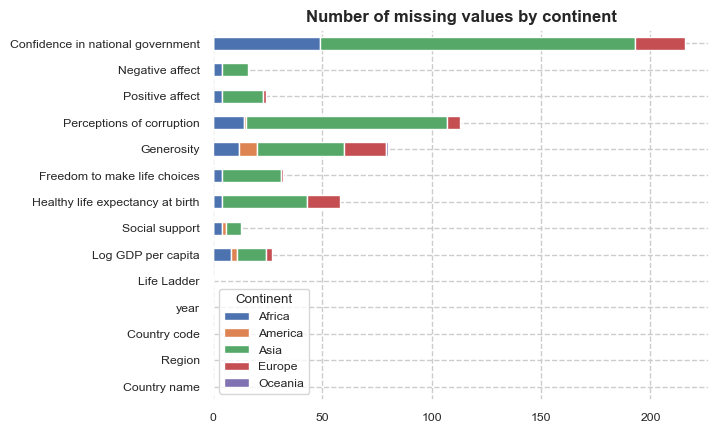

In [8]:
# are there more missing values for certain continents than for others?
df_cont_miss = df_happy.set_index('Continent').isna().groupby(level=0).sum()
df_cont_miss.transpose().plot(kind="barh", stacked=True)
plt.title("Number of missing values by continent", size=12, fontweight="bold")
plt.show()

Observation
* Most missing values come from Asia, followed by Africa, Europe, America and lastly Oceania with no missing values.

### Missing Value Imputation

In the following, missing values are filled in using k nearest neighbors imputation. The k nearest neighbors method was chosen because it is one of the methods used in the World Happiness Report to fill in missing values (Helliwell et al., 2022a, p. 49). In order not to limit the original variability of the data, a small number of neighbors (k=3) was selected (Beretta & Santaniello, 2016, p. 204).

In [9]:
# filter for columns with float values, since these contain relevant information for the k nearest neighbor method
df_float = df_happy.select_dtypes(include=["float"]) 

# impute missing values using the k nearest neighbor imputer with k = 3
imputer = KNNImputer(n_neighbors=3)
nomiss_data = imputer.fit_transform(df_float)
df_nomiss = pd.DataFrame(nomiss_data, columns=df_float.columns)
display(df_nomiss.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Life Ladder                        2089 non-null   float64
 1   Log GDP per capita                 2089 non-null   float64
 2   Social support                     2089 non-null   float64
 3   Healthy life expectancy at birth   2089 non-null   float64
 4   Freedom to make life choices       2089 non-null   float64
 5   Generosity                         2089 non-null   float64
 6   Perceptions of corruption          2089 non-null   float64
 7   Positive affect                    2089 non-null   float64
 8   Negative affect                    2089 non-null   float64
 9   Confidence in national government  2089 non-null   float64
dtypes: float64(10)
memory usage: 163.3 KB


None

Observation
* The dataset no longer contains any missing values.

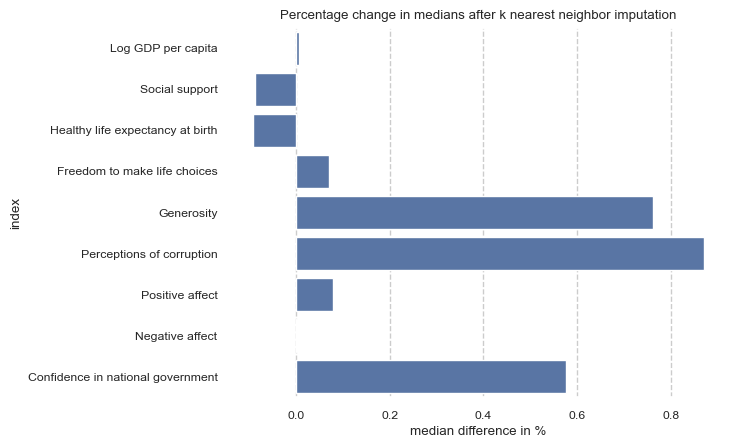

In [10]:
# identify the columns which had missing values
cols_with_miss = df_float.columns[df_float.isnull().any()]

# calculate the median for all columns before and after imputation of missing values
med_miss = df_float[cols_with_miss].median()
med_nomiss = df_nomiss[cols_with_miss].median()

# calculate the percentage change in medians
df_med = pd.concat([med_miss, med_nomiss], axis=1)
df_med = df_med.rename(columns={0: "before_imputation", 1: "after_imputation"})
df_med["median difference in %"] = ((df_med["before_imputation"] - df_med["after_imputation"])/df_med["before_imputation"])*100

# display the percentage change in medians  
ax1 = sns.barplot(df_med.reset_index(), x="median difference in %", y="index")
plt.title("Percentage change in medians after k nearest neighbor imputation")
plt.show()

Observation
* The percentage change in the median is less than one percent for all variables, so it can be assumed that the central tendency of the variables was not strongly influenced by the missing value imputation.

In [11]:
# merge the dataset without any missing values with the non-float columns
df_nofloat = df_happy.select_dtypes(exclude="float")
df_happy_v2 = df_nofloat.join(df_nomiss)
df_happy_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country name                       2089 non-null   object 
 1   Continent                          2089 non-null   object 
 2   Region                             2089 non-null   object 
 3   Country code                       2089 non-null   object 
 4   year                               2089 non-null   int64  
 5   Life Ladder                        2089 non-null   float64
 6   Log GDP per capita                 2089 non-null   float64
 7   Social support                     2089 non-null   float64
 8   Healthy life expectancy at birth   2089 non-null   float64
 9   Freedom to make life choices       2089 non-null   float64
 10  Generosity                         2089 non-null   float64
 11  Perceptions of corruption          2089 non-null   float

### Final Preprocessing

Of interest is current data on SWB that is not affected by the coronavirus pandemic. For this reason, the data is filtered by the year 2019. Furthermore, this study focuses on two variables in the dataset: SWB ("Life Ladder") and life expectancy ("Healthy life expectancy at birth"). The dataset is filtered according to these variables and the variables are renamed for better understanding. In addition, the number of countries per continent is considered in order to assess whether data from enough countries is available for all continents and regions. 

In [12]:
# filter for data from 2019
df_19 = df_happy_v2.loc[df_happy_v2["year"] == 2019]

In [13]:
# filter for the variables of interest and rename them
df_19 = df_19[["Country name", "Continent", "Region", "Country code", "Life Ladder", "Healthy life expectancy at birth"]].rename(
    columns={"Life Ladder": "Subjective Well-Being", "Healthy life expectancy at birth": "Life Expectancy"}
)

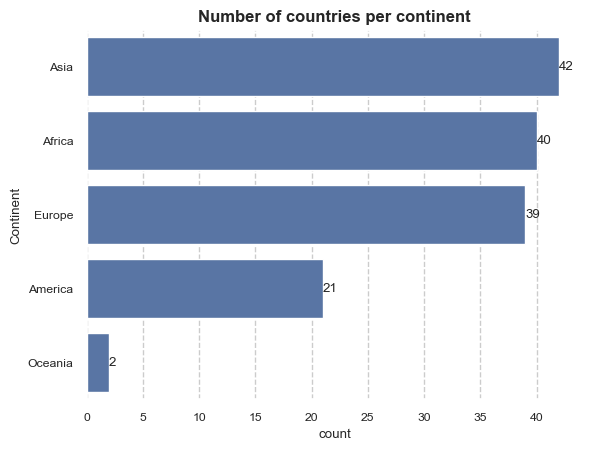

In [14]:
# plot sample sizes per continent 
def plot_n_countries_per_cont():
    ax = plt.subplot() 
    ax = sns.countplot(data=df_19, y="Continent", order=df_19["Continent"].value_counts().index, ax=ax)
    ax.bar_label(ax.containers[0])
    plt.title("Number of countries per continent", size=12, fontweight="bold")
    plt.show()

plot_n_countries_per_cont()

Observations
* For Oceania, the data of only two countries are included.
* For the other continents, the data of at least 20 countries are included. 

In [15]:
# check the countries from Oceania
df_19[df_19["Continent"] == "Oceania"]["Country name"]

84        Australia
1326    New Zealand
Name: Country name, dtype: object

Observations
* To avoid excluding the data from ANZ, ANZ were counted as "America", as was done in the World Happiness Report (Helliwell et al., 2022a, p. 29).  

In [16]:
# let Oceania count as America
df_19_oc = df_19.copy()  # to be able to use the dataset with Oceania again later if necessary
df_19 = df_19.replace("Oceania", "America")

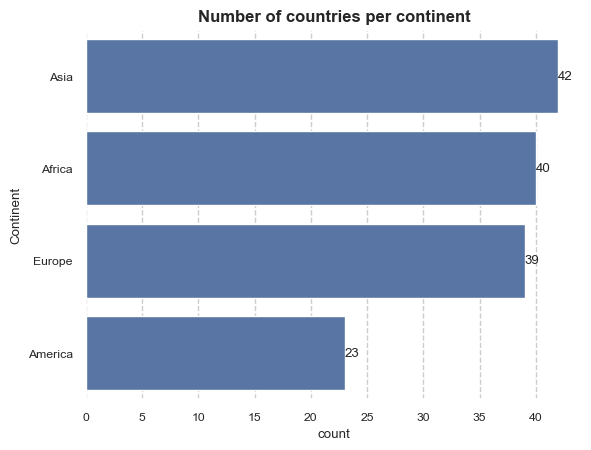

In [17]:
# plot sample sizes per continent again
plot_n_countries_per_cont()

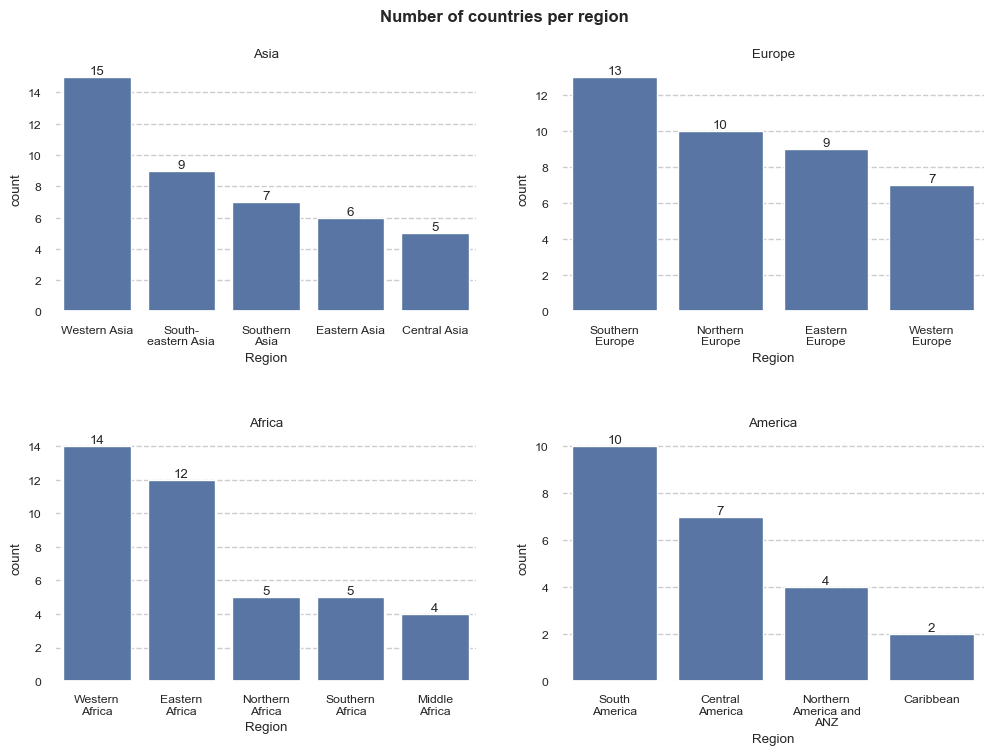

In [18]:
# define a function that wraps labels to improve the readability of diagrams
def wrap_labels(ax, width, break_long_words=False):  # function taken from Petrou (2021, section "wrapping the labels") 
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

# define a function that creates the same plot for each continent 
def plot_regions(data, plot_type, title=None, column=None, estimator=None, errorbar=None, hue=None):
    # get continent names
    continents = data["Continent"].unique().tolist()

    # set up the figure
    fig = plt.figure(figsize=(12, 8))
    plt.subplots_adjust(hspace=0.5)

    # plot one diagram per continent
    for n, continent in enumerate(continents, 1):
        df_cont = data.loc[data["Continent"] == continent]
        if len(continents) == 4:
            ax = plt.subplot(2, 2, n)
        elif len(continents) == 5:
            ax = plt.subplot(3, 2, n)
        if plot_type == "count":
            sns.countplot(data=df_cont, x="Region", order=df_cont["Region"].value_counts().index, ax=ax)
            ax.bar_label(ax.containers[0])
        elif plot_type == "bar":
            if estimator is not None:
                sns.barplot(data=df_cont, x="Region", y=column, hue=hue, estimator=estimator, errorbar=errorbar, ax=ax)
            else:
                sns.barplot(data=df_cont, x="Region", y=column, hue=hue, ax=ax)
        if column == "Subjective Well-Being":
            plt.ylim(0, 10)  # to display the theoretically possible range of values 
        ax.set_title(continent)
        wrap_labels(ax, 12)

    # add a main title if one was provided
    if title is not None:
        fig.suptitle(title, y=0.95, size=12, fontweight="bold")

# plot sample sizes per region
plot_regions(df_19, "count", title="Number of countries per region")

Observations
* The different regions include different numbers of countries.
* No region includes more than 15 countries.
* Six regions include no more than 5 countries.   
* Only two countries are included in the dataset for the Caribbean. With only two countries, it makes little sense to look at the distribution (although it is also debatable whether this makes sense with four or five countries in a region). For this reason, the medians of the regions are examined below. Perhaps it makes sense to assign the Caribbean to another region based on similarities in their SWB. 

In [19]:
# examine the medians of the American regions
america = df_19.loc[df_19["Continent"] == "America"].groupby("Region")
america_med = america["Subjective Well-Being"].median()
america_med

Region
Caribbean                  6.157
Central America            6.262
Northern America and ANZ   7.157
South America              5.971
Name: Subjective Well-Being, dtype: float64

Observation
* Based on the median subjective well-being, the Caribbean is very similar to Central America. It therefore seems reasonable to count the Caribbean as part of Central America, given that it is also geographically very close to Central America. 

In [20]:
# assign the Caribbean countries to Central America
df_19_car = df_19.copy()  # to be able to use the dataset with the Caribbean again later if necessary
df_19 = df_19.replace("Caribbean", "Central America")

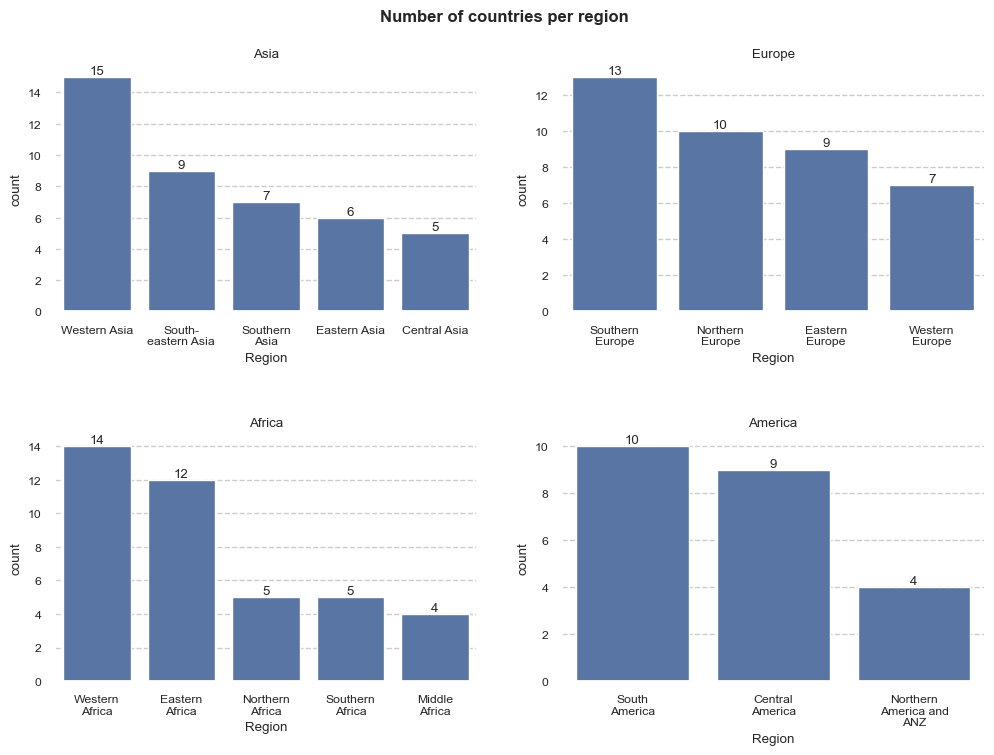

In [21]:
# check if the assignment worked (plot again the sample sizes per region)
plot_regions(df_19, "count", title="Number of countries per region")

## Distribution of Subjective Well-Being

As the primary focus is on SWB, the following section looks at the global distribution of SWB, as well as at the distribution of SWB in the different continents and regions. Histograms, kernel density estimate plots and violin plots are used for this purpose. 

### Global Distribution of Subjective Well-Being

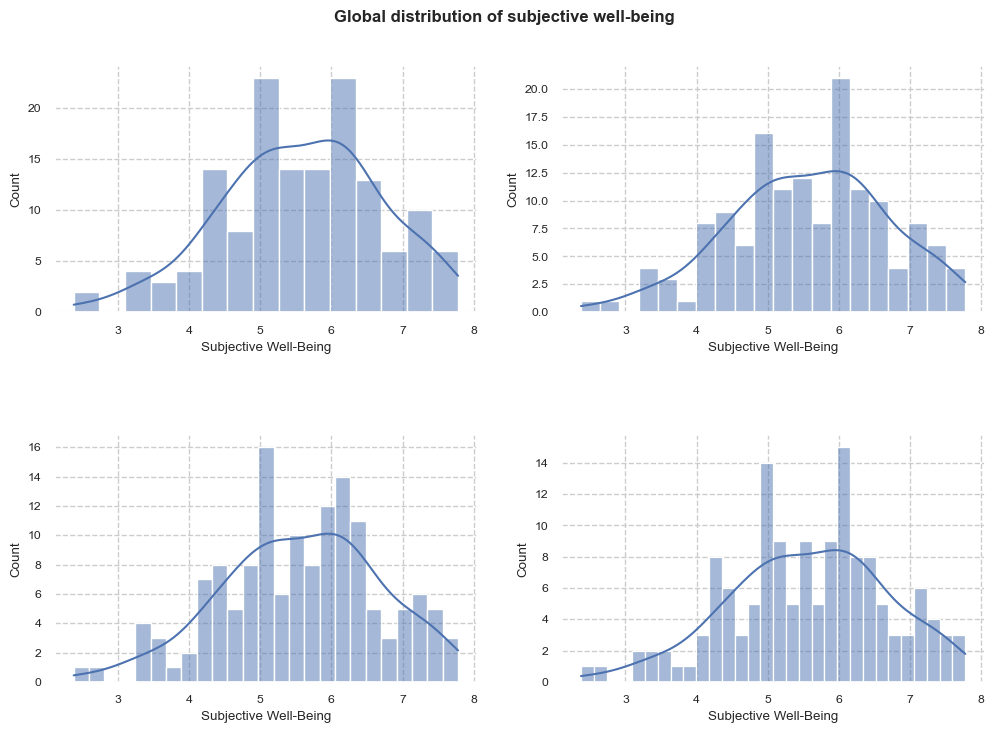

In [22]:
# plot histograms with varying bin sizes
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)

bin_sizes = [15, 20, 25, 30]
for n, bin in enumerate(bin_sizes, 1):
    ax = plt.subplot(2, 2, n)
    sns.histplot(data=df_19, x="Subjective Well-Being", bins=bin, kde=True)

fig.suptitle("Global distribution of subjective well-being", y=0.95, size=12, fontweight="bold")
plt.show()

Observations
* The distribution of SWB deviates from a normal distribution: it is more compressed than a normal distribution and there seem to be two peaks. These are more visible in the histograms than in the kernel density estimate plot.
* The higher the number of bins, the better the deviations from the normal distribution can be recognized. 

### Distribution of Subjective Well-Being in Different Continents

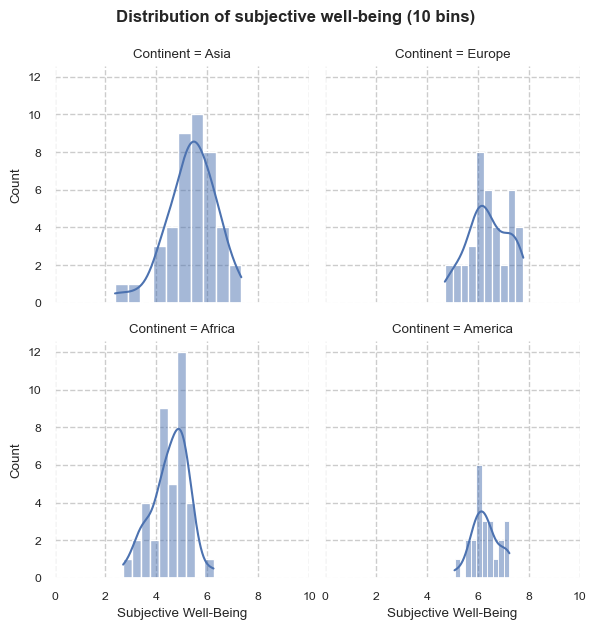

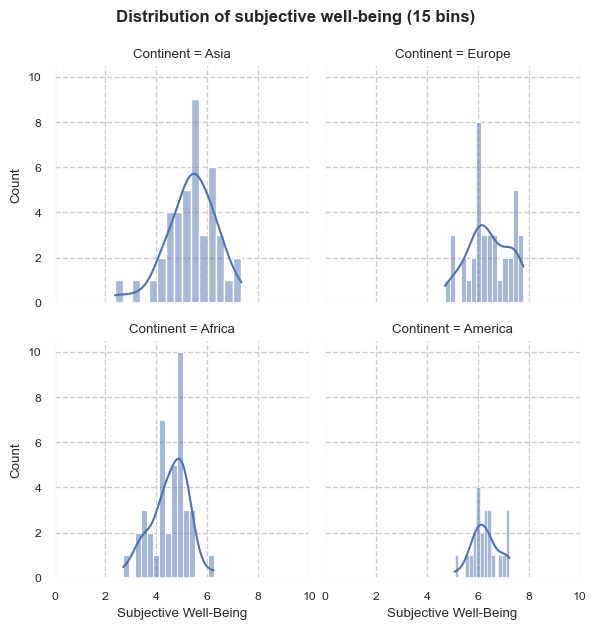

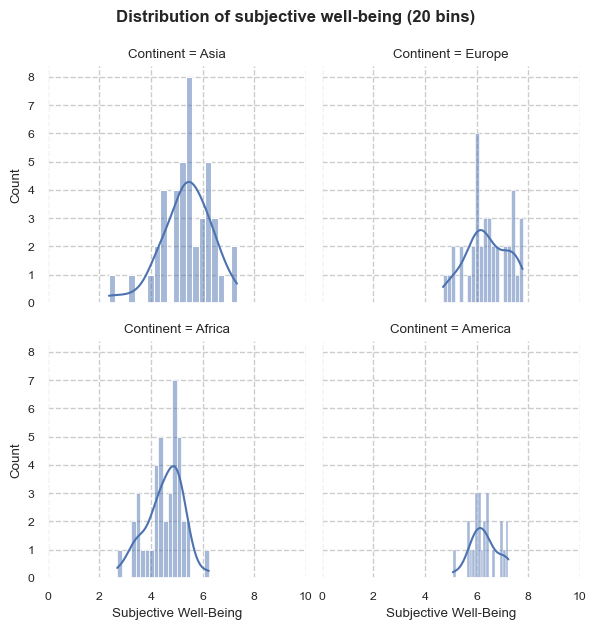

In [23]:
# plot histograms with varying bin sizes to show the distribution of SWB in the different continents
continents = df_19["Continent"].unique().tolist()
continents.sort()  # sort continents alphabetically

def plot_histograms(data, variable, bins, grouping, col_wrap, continent_name=None):
    g = sns.FacetGrid(data, col=grouping, col_wrap=col_wrap)
    g.map(sns.histplot, variable, bins=bins, kde=True)
    if grouping == "Continent":
        title = f"Distribution of subjective well-being ({bins} bins)"
    elif grouping == "Region":
        title = f"Distribution of subjective well-being in {continent_name} ({bins} bins) "
    g.fig.suptitle(title, y=1.04, size=12, fontweight="bold")
    if variable == "Subjective Well-Being":
        g.set(xlim=(0, 10))  # to display the possible range of SWB values
    plt.show()

plot_histograms(df_19, "Subjective Well-Being", 10, "Continent", 2)
plot_histograms(df_19, "Subjective Well-Being", 15, "Continent", 2)
plot_histograms(df_19, "Subjective Well-Being", 20, "Continent", 2)

Observations
* Of all the continents, the distribution of SWB in Asia most closely resembles a normal distribution.
* For all other continents, the distribution of SWB is not symmetrical.
* In Europe and America, there is another, smaller peak to the right of the absolute peak - both distributions therefore tend to be bimodal.
* In Africa, on the other hand, there is a small, not very pronounced bulge to the left of the absolute peak.
* Outliers are not recognizable in the histograms at first glance.
* The high number of bins (15 or 20) is not appropriate for America, as there is probably not enough data available. For Asia, the histogram with the highest number of bins selected provides the most information about the distribution, as this looks more similar to a normal distribution with a lower number of bins than with a higher number of bins. 

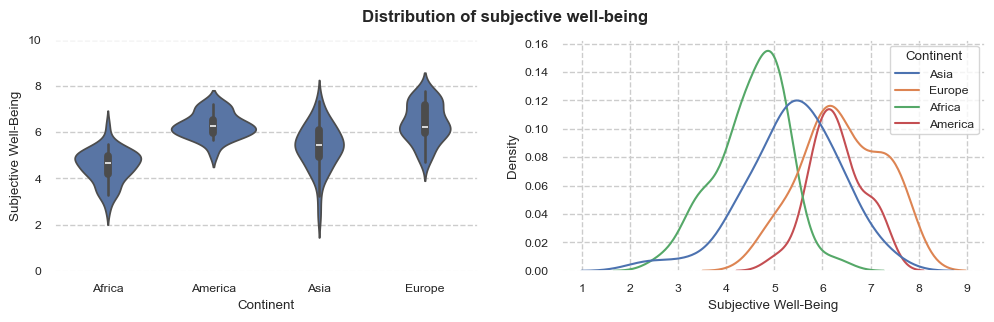

In [24]:
# plot violin plots and kernel density estimate plots for easy continent comparison
def plot_violin_kde(data, grouping, variable, continent_name=None):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
    sns.violinplot(data=data, x=grouping, y=variable, ax=ax1, order=continents)
    ax1.set_ylim(0, 10)
    sns.kdeplot(data=data, x=variable, hue=grouping, ax=ax2)
    if grouping == "Continent": 
        plt.suptitle("Distribution of subjective well-being", size=12, fontweight="bold")
    elif grouping == "Region":
        plt.suptitle(f"Distribution of subjective well-being in {continent_name}", size=12, fontweight="bold")
    wrap_labels(ax1, 12)
    plt.show()
    

plot_violin_kde(df_19, "Continent", "Subjective Well-Being")

Observations
* The observations gained from the histograms are also visible here.
* In addition, the direct comparison of the continents is better possible than with the histograms alone.
* The distribution of SWB varies depending on the continent.
* America and Europe are more similar to each other than the other continents.
* Differences in location and variability are also made clear by displaying the median and the interquartile range (IQR) as part of the boxplot within the violin plot (these are discussed in more detail below).

### Distribution of Subjective Well-Being in Different Regions

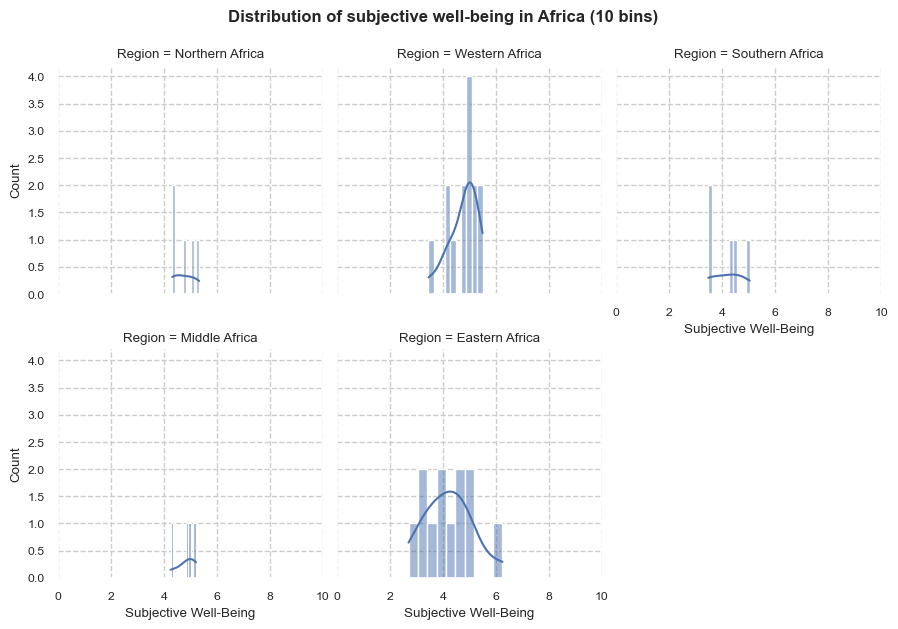

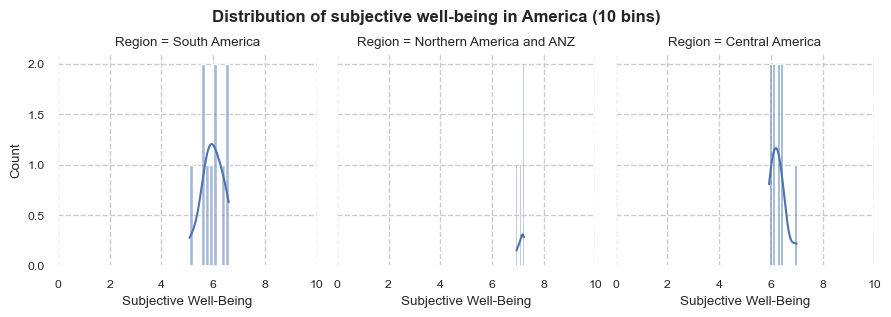

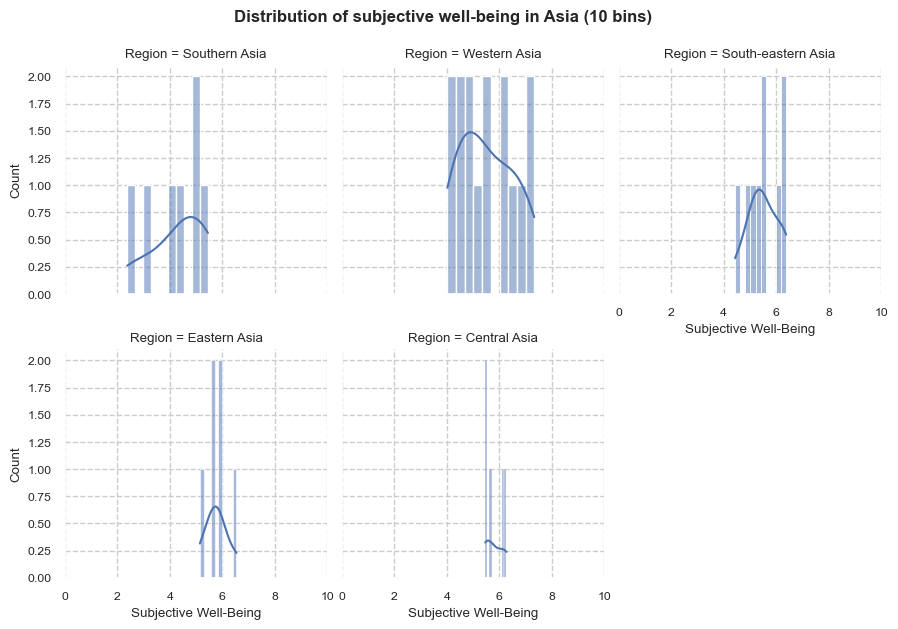

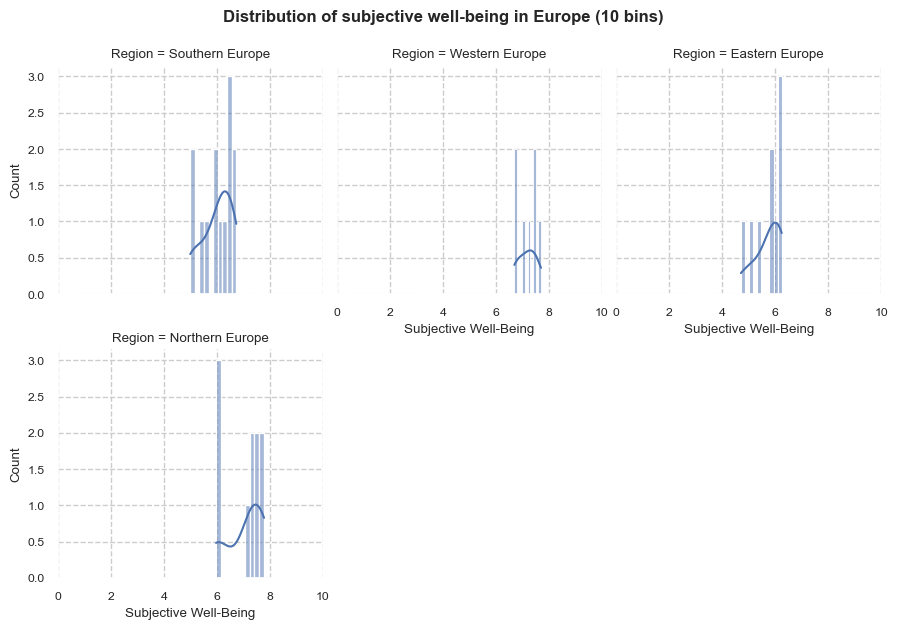

In [25]:
# plot histograms to show the distribution of SWB in the different continent regions
for n, continent in enumerate(continents):
    df_cont = df_19[df_19["Continent"] == continent]
    plot_histograms(df_cont, "Subjective Well-Being", 10, "Region", 3, continent)

Observations
* When interpreting the histograms, the small sample size for the individual regions should be noted (see section "Final preprocessing").
* This makes the bin sizes very small and difficult to see, especially in regions with a small number of countries, such as Central Africa or North America and ANZ.
* Nevertheless, the histograms all show deviations from the normal distribution.
* At first glance, outliers are not recognizable in the histograms, as the bins in the histograms are mostly very close to each other. 

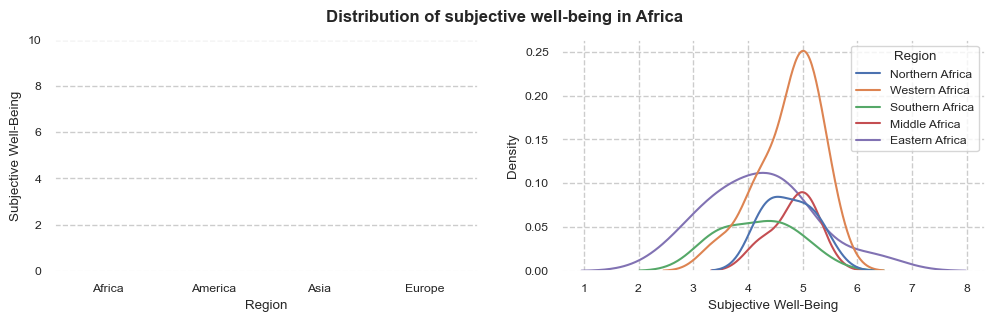

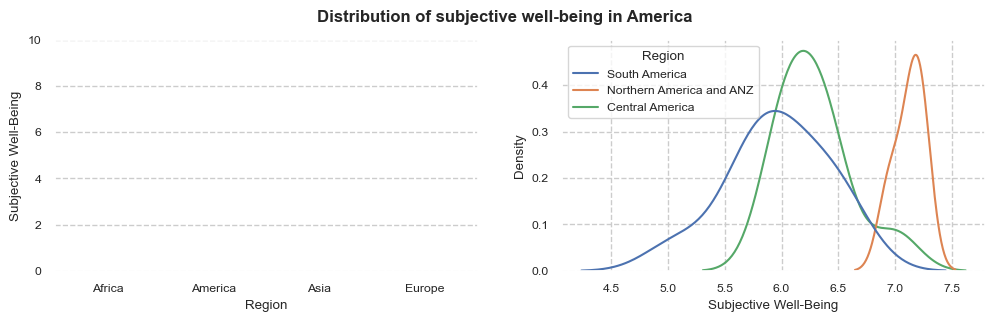

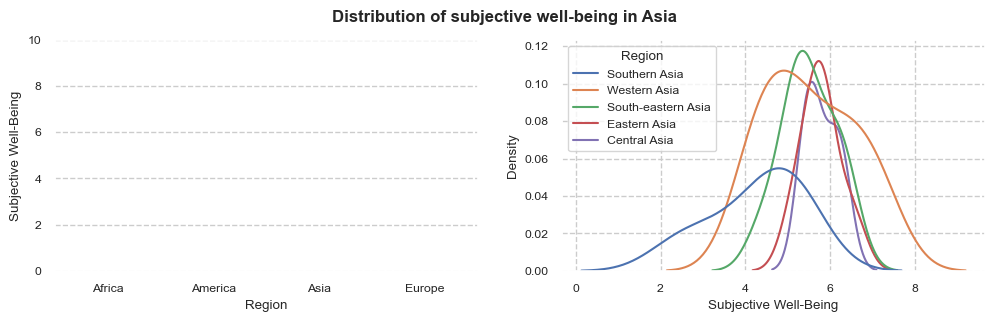

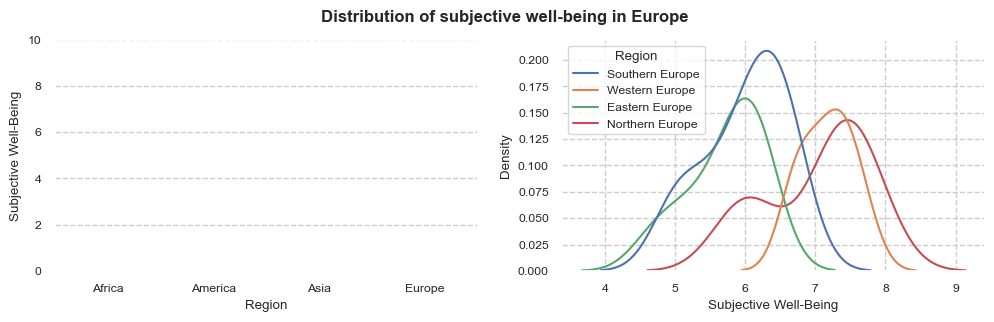

In [26]:
# plot violin plots and kernel density estimate plots for easy region comparison
for n, continent in enumerate(continents):
    df_cont = df_19[df_19["Continent"] == continent]
    plot_violin_kde(df_cont, "Region", "Subjective Well-Being", continent)

Observations
* The distribution of SWB varies further depending on the region in a continent.
* For example, the distribution of SWB in Northern Europe is almost bimodal, while in Eastern Europe it is clearly unimodal.
* However, the small sample sizes should be noted, which makes it difficult to interpret the Kernel Density Estimate and violin plots (Wilke, 2019, p. 85).

## Location and Variability of Subjective Well-Being

Even though the violin plots in particular have already provided initial information on the location and variability of SWB, both are examined in more detail below using the median and the IQR, as well as the weighted median and the quartile coefficient of dispersion (QCD) to compare the variability of SWB with the variability of life expectancy. In addition, the median of SWB is also compared with its mean value in the various continents and regions.

In [27]:
# display descriptive statistics for the overall SWB
desc = df_19["Subjective Well-Being"].describe()
desc["iqr"] = desc["75%"] - desc["25%"]
display(desc)

count   144.000
mean      5.570
std       1.113
min       2.375
25%       4.928
50%       5.594
75%       6.282
max       7.780
iqr       1.354
Name: Subjective Well-Being, dtype: float64

Observations
* The difference between the unhappiest country and the happiest country is more than 5.4 points in SWB.
* The median is slightly above the mean. 

In [28]:
# calculate the QCD to compare the variability of SWB with the variability of life expectancy
def calculate_quart_disp(data):
    q1, q3 = np.percentile(data, [25, 75])
    return (q3-q1)/(q1+q3)

quart_disp_life_ladder = calculate_quart_disp(df_19["Subjective Well-Being"])
quart_disp_life_exp = calculate_quart_disp(df_19["Life Expectancy"])
print("qartile coefficient of dispersion of SWB:", quart_disp_life_ladder)
print("qartile coefficient of dispersion of life expectancy:", quart_disp_life_exp)

qartile coefficient of dispersion of SWB: 0.12077686041592472
qartile coefficient of dispersion of life expectancy: 0.06710625948102286


Observations
* Countries differ more in their SWB than in their life expectancy. The variability of SWB is almost twice as high as the variability of life expectancy.
* This means that differences in SWB are not just explained by differences in life expectancy. 

### Location and Variability of Subjective Well-Being in Different Continents

In [29]:
# display descriptive statistics for SWB in different continents
desc_cont = df_19["Subjective Well-Being"].groupby(df_19['Continent']).describe()
desc_cont["iqr"] = desc_cont["75%"] - desc_cont["25%"]
display(desc_cont)

count  mean   std   min   25%   50%   75%   max   iqr
Continent                                                       
Africa    40.000 4.529 0.723 2.694 4.173 4.680 4.992 6.241 0.819
America   23.000 6.292 0.544 5.081 5.971 6.262 6.528 7.234 0.557
Asia      42.000 5.384 0.980 2.375 4.918 5.465 6.085 7.332 1.167
Europe    39.000 6.412 0.832 4.702 5.961 6.243 7.176 7.780 1.215

Observations
* The median SWB is similarly high in Europe as in America. It is lower in Asia and even lower in Africa.
* Considering the mean values, the ranking is the same.
* At first glance, there are no major numerical differences between the median and the mean value in all continents.

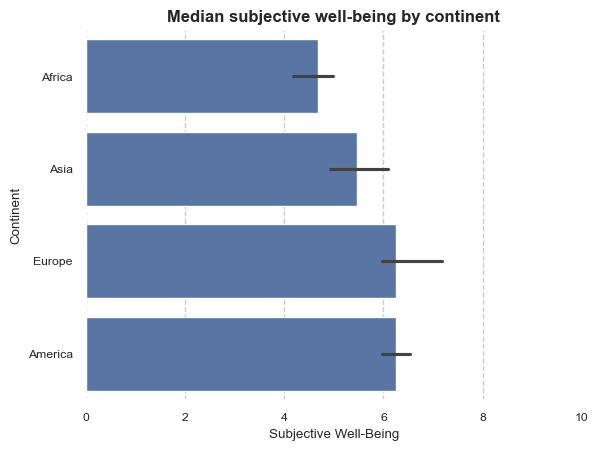

In [30]:
# visualize median SWB by continent (error bars represent the IQR)
ax = sns.barplot(data=df_19, x="Subjective Well-Being", y="Continent", estimator=np.median, errorbar=("pi", 50), order=["Africa", "Asia", "Europe", "America"])
plt.title("Median subjective well-being by continent", size=12, fontweight="bold")
plt.xlim(0, 10)
plt.show()

Observations
* SWB is highest in America, followed by Europe, Asia and Africa.
* The variability (measured by the IQR, which is represented by the error bars) is higher in Europe and Asia than in Africa and America.
* Unlike in the other continents, the median is not the center of the IQR in Europe - it is closer to the 25th quartile value than to the 75th quartile value than in the other continents. 

Median  Mean  Difference
Continent                          
Africa      4.680 4.529       0.151
America     6.262 6.292      -0.030
Asia        5.465 5.384       0.081
Europe      6.243 6.412      -0.169

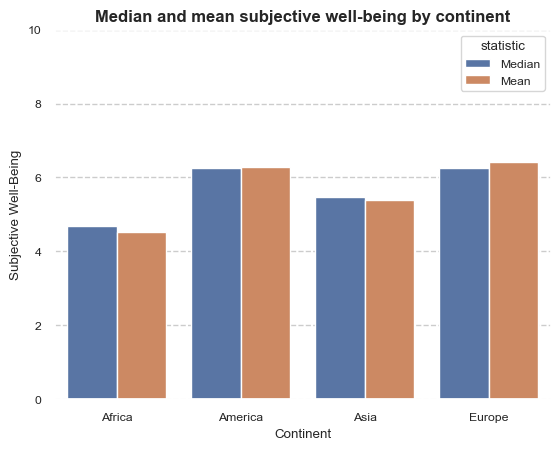

In [31]:
# build a dataset that contains the medians and means, as well as their differences
df_19_med = pd.DataFrame()
df_19_med["Median"] = desc_cont["50%"]
df_19_loc = df_19_med.copy()
df_19_loc["Mean"] = desc_cont["mean"]
df_19_diff = df_19_loc.copy()
df_19_diff["Difference"] = df_19_diff["Median"] - df_19_diff["Mean"]
display(df_19_diff)

# display differences between mean and median for each continent
df_19_locm = df_19_loc.reset_index().melt("Continent", var_name="statistic", value_name="Subjective Well-Being")
g = sns.barplot(data=df_19_locm, x="Continent", y="Subjective Well-Being", hue="statistic")
plt.ylim(0, 10)
plt.title("Median and mean subjective well-being by continent", size=12, fontweight="bold")
plt.show()

Observations
* Medians and mean values do not differ strongly in any continent. This suggests that there are few outliers in the dataset, as the mean, unlike the median, is strongly influenced by outliers (Molin, 2019, p. 19). 
* In Africa and Asia, the median is slightly higher than the mean, which indicates a left-skewed distribution.
* In America, there is almost no difference between the median and the mean.
* In Europe, the mean is slightly higher than the median, which indicates a right-skewed distribution.
* It was decided not to show the difference, as this would not reflect the actual level of the median and the mean (Schwabish, 2021, p. 85). For example, a difference of 0.17 points can be high or low depending on the scale. 

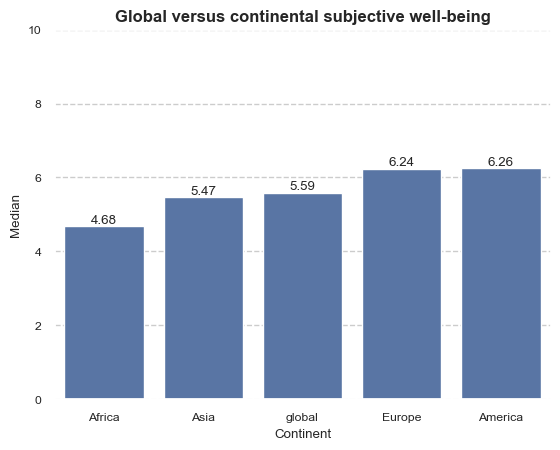

In [32]:
# calculate the global median
total_med = df_19["Subjective Well-Being"].median()
df_19_med_global = df_19_med.copy().reset_index()
df_19_med_global.loc[len(df_19_med_global)] = ["global", total_med]
df_19_med_global["Median"] = round(df_19_med_global["Median"], 2)

# compare the SWB of the continents with the global median SWB
ax = sns.barplot(data=df_19_med_global, x="Continent", y="Median", order=df_19_med_global.sort_values("Median").Continent)
ax.bar_label(ax.containers[0])
plt.ylim(0, 10)
plt.title("Global versus continental subjective well-being", size=12, fontweight="bold")
plt.show()

Observations
* The median SWB in Africa and Asia is slightly below the global median, while the median SWB in Europe and America is above it.
* The global median is an unweighted median. It is possible that not all continents are equally represented in terms of their actual number of countries, in which case a weighted median may be more informative than an unweighted median (Bruce et al., 2020, p. 10). 

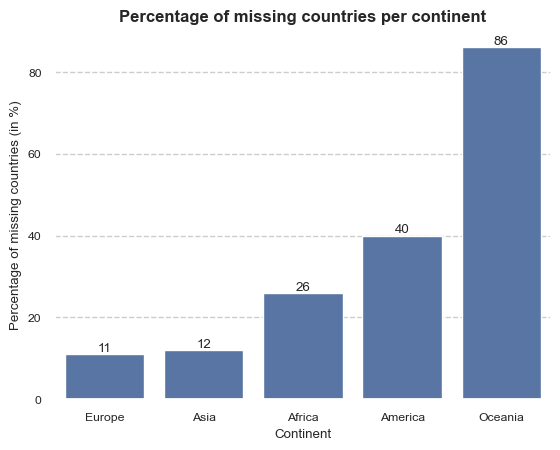

In [33]:
# Find out how representative the dataset is for the individual continents 

# create a dataframe with the number of countries per continent in the dataset and the actual number of countries taken from Shvili (2023)
true_count = {"Asia": 48, "Africa": 54, "Europe": 44, "America": 35, "Oceania": 14}
counts = df_19_oc["Continent"].value_counts()
df_counts = pd.DataFrame(counts).reset_index().rename(columns={"count": "Count in df"})
df_counts["Actual count"] = df_counts["Continent"].map(true_count)
df_counts["Missing"] = df_counts["Actual count"]- df_counts["Count in df"]
df_counts["Percent"] = round((df_counts["Missing"]/df_counts["Actual count"])*100)

# visualize the percentage of missing countries per continent
ax = sns.barplot(data=df_counts, x="Continent", y="Percent", order=df_counts.sort_values("Percent").Continent)
ax.set(ylabel="Percentage of missing countries (in %)")
ax.bar_label(ax.containers[0])
plt.title("Percentage of missing countries per continent", size=12, fontweight="bold")
plt.show()

Observations
* Not all continents are equally represented in the dataset. For example, data is only available for 60% of the countries in America.
* Asia and Europe are more strongly represented than Africa and America.
* Oceania is the least represented continent in the dataset.
* For this reason, a median weighted by the percentage of missing countries in the respective continents may provide a more informative picture than an unweighted median. 

In [34]:
# add a column to the dataset containing the weights (percentage of missing countries in the continent)
percent_missing = dict(zip(df_counts["Continent"], df_counts["Percent"]))
weight = [percent_missing[cont] for cont in df_19_oc["Continent"]]
df_19_oc.insert(2, 'Weights', weight) 

# define a function to calculate the weighted median (see Bruce et al., 2020, p. 13)
def calculate_weighted_median(data, col, weight_col):
    weighted = wquantiles.median(data[col], weights=data[weight_col])
    original = data[col].median()   
    return weighted, original

weighted_med, original_med = calculate_weighted_median(df_19_oc, "Subjective Well-Being", "Weights")
print('weighted median:', weighted_med)
print('unweighted median:', original_med)

weighted median: 5.6613300030048075
unweighted median: 5.594324588775635


Observations
* The unweighted median is lower than the weighted median, which indicates that continents with high SWB are underrepresented in the dataset. 
* However, it is possible that ANZ, for example, have a higher level of SWB than the countries of Oceania that are not included in the dataset (such as Papua New Guinea, Fiji, Solomon Islands). 
* Because ANZ receive such large weights in the current weighting and their SWB may differ from that of other countries in Oceania, in the following it is examined what happens to the weighted median if Oceania is excluded before the calculation. 

In [35]:
# calculate the weighted median after excluding Oceania
df_19_wo_oc = df_19_oc.loc[df_19_oc["Continent"] != "Oceania"].copy()
weighted_med_wo_oc, original_med_wo_oc = calculate_weighted_median(df_19_wo_oc, "Subjective Well-Being", "Weights")
print('weighted median:', weighted_med_wo_oc)
print('unweighted median:', original_med_wo_oc)

weighted median: 5.48871952609012
unweighted median: 5.525820970535278


Observations
* If Oceania is excluded, the picture is different: the unweighted median is now higher than the weighted median.
* Accordingly, the weighted median is strongly influenced by the choice of weights.
* It is unclear which weighted median corresponds more closely to reality.

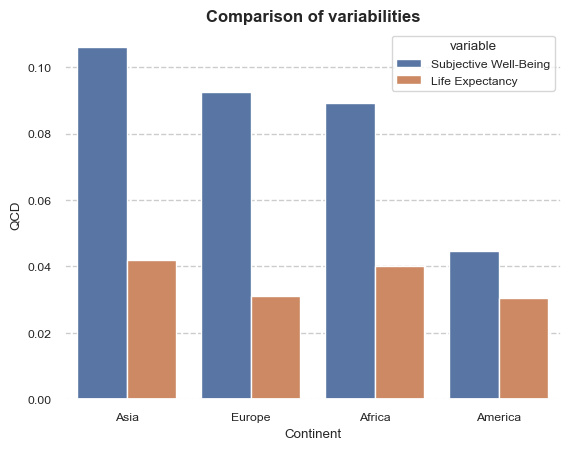

In [36]:
# calculate the QCD to compare the variability of SWB with the variability of life expectancy by continent
df_qcd = df_19[["Continent", "Subjective Well-Being", "Life Expectancy"]].copy()
df_qcd_m = df_qcd.melt("Continent", var_name="variable", value_name="QCD")
ax = sns.barplot(data=df_qcd_m, x="Continent", y="QCD", hue="variable", estimator=calculate_quart_disp, errorbar=None)
plt.title("Comparison of variabilities", size=12, fontweight="bold")
plt.show()

Observations
* In all continents, the variability of SWB is significantly higher than the variability of life expectancy. 
* The difference between the two variabilities is least pronounced in America. In America, the variability of SWB is significantly lower than in the other continents, while the variability of life expectancy is similar to that in Europe.

### Location and Variability of Subjective Well-Being in Different Regions

In [37]:
# display descriptive statistics for SWB in different regions
regions = df_19.groupby(["Continent", "Region"])
desc_reg = regions["Subjective Well-Being"].describe()
display(desc_reg)

count  mean   std   min   25%   50%   75%  \
Continent Region                                                                
Africa    Eastern Africa           12.000 4.214 0.953 2.694 3.557 4.219 4.697   
          Middle Africa             4.000 4.829 0.408 4.251 4.748 4.926 5.006   
          Northern Africa           5.000 4.755 0.447 4.315 4.328 4.745 5.057   
          Southern Africa           5.000 4.170 0.669 3.471 3.512 4.396 4.436   
          Western Africa           14.000 4.761 0.561 3.447 4.385 4.972 5.092   
America   Central America           9.000 6.288 0.323 5.930 6.086 6.262 6.432   
          Northern America and ANZ  4.000 7.123 0.131 6.944 7.068 7.157 7.212   
          South America            10.000 5.965 0.446 5.081 5.708 5.971 6.284   
Asia      Central Asia              5.000 5.810 0.381 5.464 5.474 5.685 6.154   
          Eastern Asia              6.000 5.786 0.463 5.144 5.587 5.781 5.907   
          South-eastern Asia        9.000 5.504 0.627 4.434 5.197 5.428 6.022   
          Southern Asia             7.000 4.264 1.104 2.375 3.731 4.443 5.060   
          Western Asia             15.000 5.533 1.074 4.024 4.677 5.467 6.349   
Europe    Eastern Europe            9.000 5.721 0.536 4.702 5.441 5.821 6.130   
          Northern Europe          10.000 7.033 0.721 5.970 6.337 7.326 7.510   
          Southern Europe          13.000 6.004 0.587 4.995 5.626 6.095 6.445   
          Western Europe            7.000 7.174 0.366 6.690 6.904 7.195 7.415   

                                     max  
Continent Region                          
Africa    Eastern Africa           6.241  
          Middle Africa            5.213  
          Northern Africa          5.330  
          Southern Africa          5.035  
          Western Africa           5.489  
America   Central America          6.998  
          Northern America and ANZ 7.234  
          South America            6.600  
Asia      Central Asia             6.272  
          Eastern Asia             6.537  
          South-eastern Asia       6.378  
          Southern Asia            5.449  
          Western Asia             7.332  
Europe    Eastern Europe           6.243  
          Northern Europe          7.780  
          Southern Europe          6.733  
          Western Europe           7.694

Observation
* Because this table is rather cluttered, the median and IQR of the individual regions are visualized below.

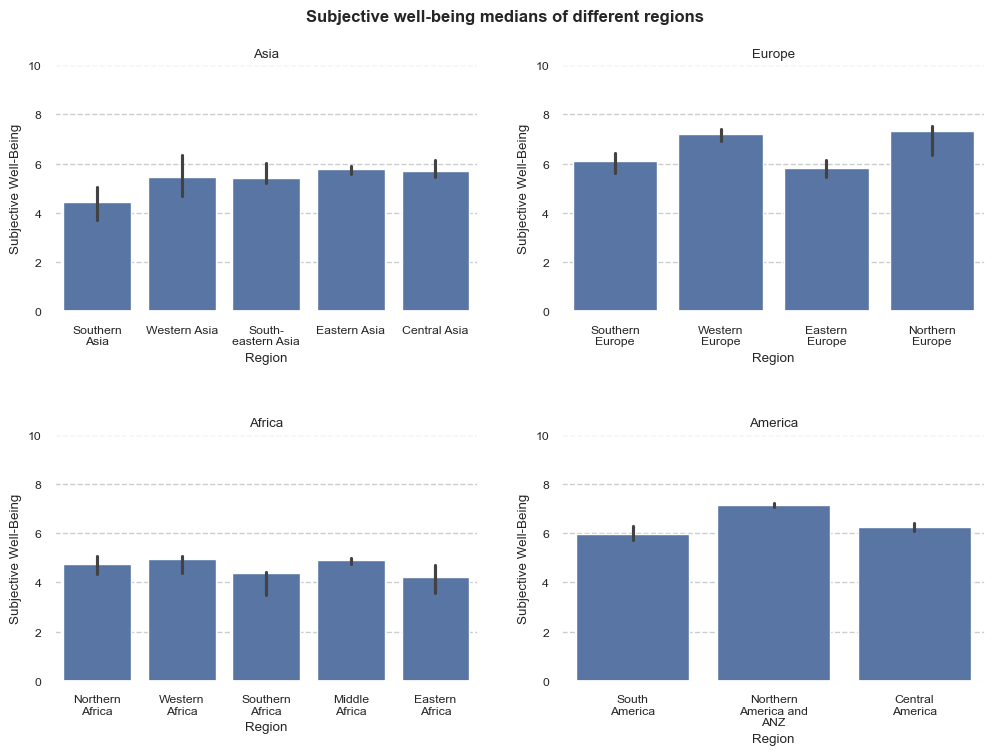

In [38]:
# visualize median SWB by region (error bars represent the IQR)
plot_regions(df_19, "bar", column="Subjective Well-Being", estimator=np.median, errorbar=("pi", 50), title="Subjective well-being medians of different regions")

Observations
* The regions differ in their SWB. 
* Asia: the SWB of South Asia is considerably lower than that of the other regions. The IQR is lowest in East Asia and highest in West Asia.
* Europe: Western and Northern Europe are happier than Southern and Eastern Europe. Variability is lowest in Western Europe.
* Africa: East and South Africa are less happy than the other regions. The IQR is particularly low in Central Africa. 
* America: North America and ANZ are happier than South and Central America. The variability there is also lower than in the other two regions.
* The differences in variability may also be due to the different sample sizes in the regions. 

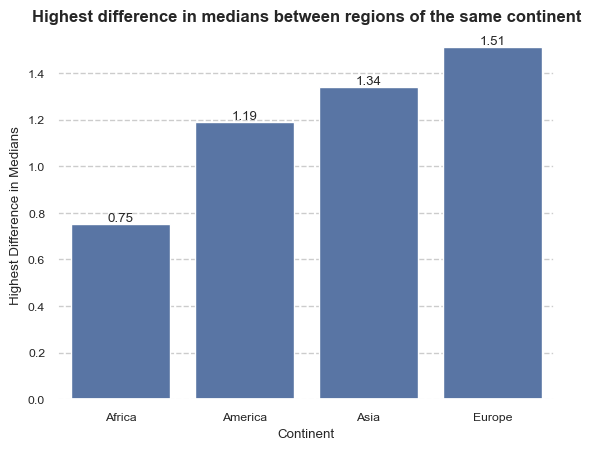

In [39]:
# for each continent, calculate the difference in the median between the region with the highest median and the region with the lowest median
df_19_med_reg = pd.DataFrame()
df_19_med_reg["Median"] = desc_reg["50%"]
df_19_med_diff = df_19_med_reg.reset_index().pivot(index="Continent", columns="Region", values="Median").transpose()
med_diff_desc = df_19_med_diff.describe()
min_med = med_diff_desc.loc["min"]
max_med = med_diff_desc.loc["max"]
diff_med = (max_med - min_med).round(2)
df_diff_med = pd.DataFrame(diff_med, columns=["Highest Difference in Medians"])

# visualize the highest difference in medians for each continent
ax = sns.barplot(data=df_diff_med.reset_index(), x="Continent", y="Highest Difference in Medians", order=["Africa", "America", "Asia", "Europe"])
ax.bar_label(ax.containers[0])
plt.title("Highest difference in medians between regions of the same continent", size=12, fontweight="bold")
plt.show()

Observations
* The difference between the highest and lowest median is highest in Europe.
* In Africa, the difference is considerably smaller than in the other continents, which means that the regions here are more homogeneous in terms of SWB than in the other continents. 

Median  Mean  Difference
Continent Region                                            
Africa    Eastern Africa             4.219 4.214       0.006
          Middle Africa              4.926 4.829       0.097
          Northern Africa            4.745 4.755      -0.010
          Southern Africa            4.396 4.170       0.226
          Western Africa             4.972 4.761       0.211
America   Central America            6.262 6.288      -0.025
          Northern America and ANZ   7.157 7.123       0.034
          South America              5.971 5.965       0.006
Asia      Central Asia               5.685 5.810      -0.125
          Eastern Asia               5.781 5.786      -0.005
          South-eastern Asia         5.428 5.504      -0.076
          Southern Asia              4.443 4.264       0.179
          Western Asia               5.467 5.533      -0.066
Europe    Eastern Europe             5.821 5.721       0.100
          Northern Europe            7.326 7.033       0.294
          Southern Europe            6.095 6.004       0.091
          Western Europe             7.195 7.174       0.022

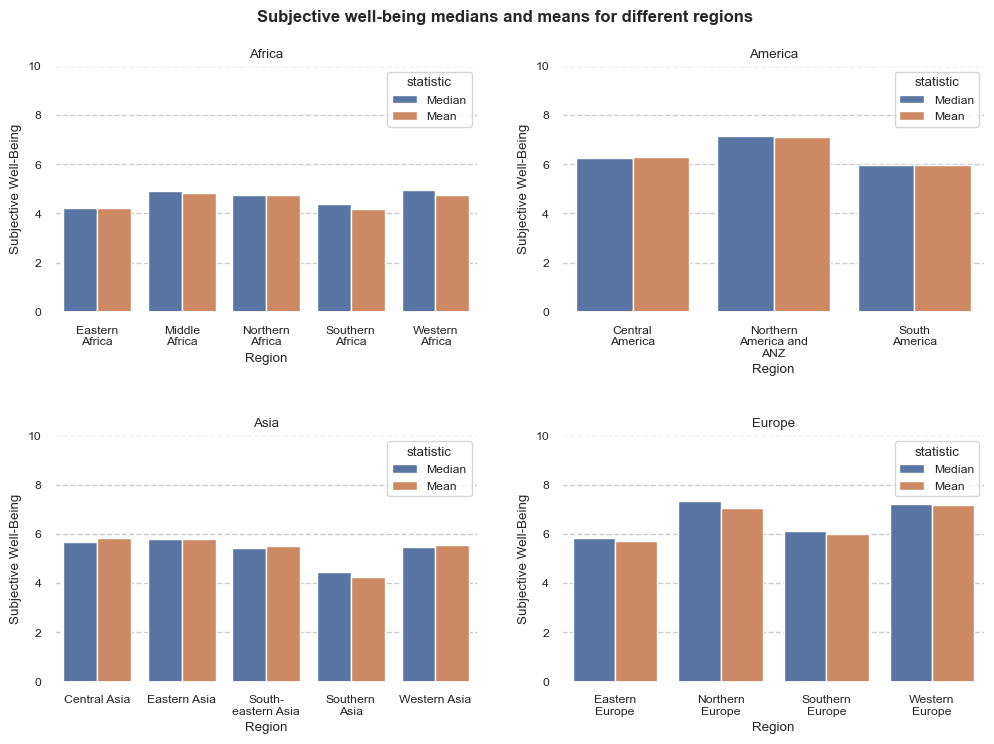

In [40]:
# build a dataset that contains the medians and means, as well as their differences
df_19_loc_reg = df_19_med_reg.copy()
df_19_loc_reg["Mean"] = desc_reg["mean"]
df_19_sub_diff = df_19_loc_reg.copy()
df_19_sub_diff["Difference"] = df_19_sub_diff["Median"] - df_19_sub_diff["Mean"]
display(df_19_sub_diff)

# display differences between median and mean for each region
df_19_loc_regm = df_19_loc_reg.reset_index().melt(["Continent", "Region"], var_name="statistic", value_name="Subjective Well-Being")
plot_regions(df_19_loc_regm, "bar", column="Subjective Well-Being", hue="statistic", title="Subjective well-being medians and means for different regions")

Observations
* Medians and mean values do not differ strongly in any region. This suggests that there are few outliers in the dataset, as the mean, unlike the median, is strongly influenced by outliers (Molin, 2019, p. 19).
* Median and mean are very close to each other, especially in America. 

In [41]:
# examine the IQR values in the different regions more closely
df_19_iqr = pd.DataFrame()
df_19_iqr["IQR"] = desc_reg["75%"] - desc_reg["25%"]
df_19_iqr.reset_index(inplace=True)
df_wide = df_19_iqr.pivot(index="Continent", columns="Region", values="IQR").transpose().reset_index()

# for each continent, indicate the region with the highest IQR and the region with the lowest IQR
continent = []
country_max = []
country_min = []
val_max = []
val_min = []
for column in df_wide:
    if column == "Region":
        continue
    c_max = df_wide.loc[df_wide[column].idxmax()]["Region"]
    v_max = df_wide[column].max()
    c_min = df_wide.loc[df_wide[column].idxmin()]["Region"]
    v_min = df_wide[column].min()
    continent.append(column)
    country_max.append(c_max)
    country_min.append(c_min)
    val_max.append(v_max)
    val_min.append(v_min)

data = {
    "Continent": continent,
    "Country with max IQR": country_max,
    "Max IQR": val_max,
    "Country with min IQR": country_min,
    "Min IQR": val_min
}

df_minmax_iqr = pd.DataFrame(data)
df_minmax_iqr["Relation highest/lowest"] = df_minmax_iqr["Max IQR"] / df_minmax_iqr["Min IQR"]
display(df_minmax_iqr)

Continent Country with max IQR  Max IQR      Country with min IQR  Min IQR  \
0    Africa       Eastern Africa    1.140             Middle Africa    0.257   
1   America        South America    0.576  Northern America and ANZ    0.145   
2      Asia         Western Asia    1.672              Eastern Asia    0.320   
3    Europe      Northern Europe    1.173            Western Europe    0.511   

   Relation highest/lowest  
0                    4.433  
1                    3.983  
2                    5.229  
3                    2.295

Observations
* The ratio of the highest to the lowest IQR is highest in Asia. West Asia has the highest IQR, which is more than five times higher than the IQR in East Asia.
* North America and ANZ have the lowest IQR overall, which means that this is the most homogeneous region. 
* Within the regions in Europe, the IQRs are most similar: here, the highest IQR (Northern Europe) is only more than twice as large as the lowest IQR (Western Europe). 

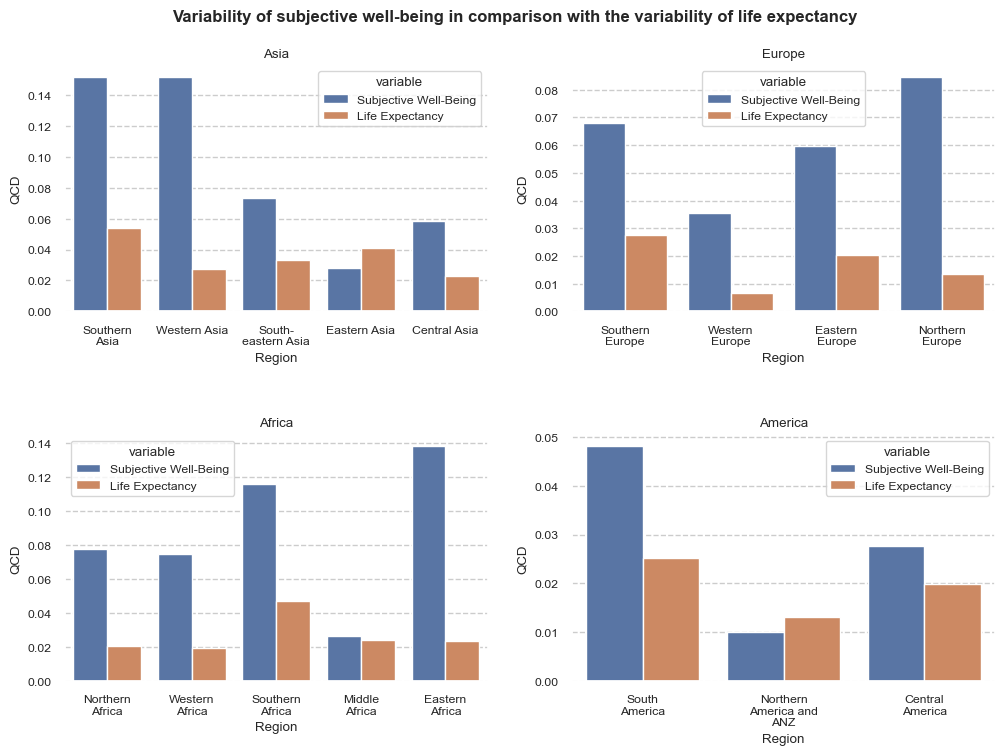

In [42]:
# calculate the QCD to compare the variability of SWB with the variability of life expectancy by region
df_qcd_reg = df_19[["Continent", "Region", "Subjective Well-Being", "Life Expectancy"]].copy()
df_qcd_regm = df_qcd_reg.melt(["Continent", "Region"], var_name="variable", value_name="QCD")

# compare the QCD of the two variables for the different regions
plot_regions(df_qcd_regm, "bar", 
             title="Variability of subjective well-being in comparison with the variability of life expectancy", 
             column="QCD", estimator=calculate_quart_disp, hue="variable")

Observations
* Both the variability of SWB and the variability of life expectancy differ depending on the region.
* In most regions, SWB varies more than life expectancy. 
* In some regions, such as Western Asia, Northern Europe and East Africa, the variability of SWB is several times greater than the variability of life expectancy.
* In two regions (Central Africa and Central America), the variability of both variables is about the same. 
* In two regions (East Asia, North America and ANZ), the variability of life expectancy is greater than the variability of SWB. 

## Covariance and Correlation Between Subjective Well-Being and Life Expectancy

In the following, the correlation between SWB and life expectancy is examined first across all continents and then in the individual continents. To this end, scatter plots are first used to determine whether the relationship between the two variables is linear. In addition, univariate and bivariate outliers are calculated to assess the appropriateness of the correlation coefficients used. Three different correlation coefficients are then calculated. 

### Correlation between subjective well-being and Life Expectancy across all continents

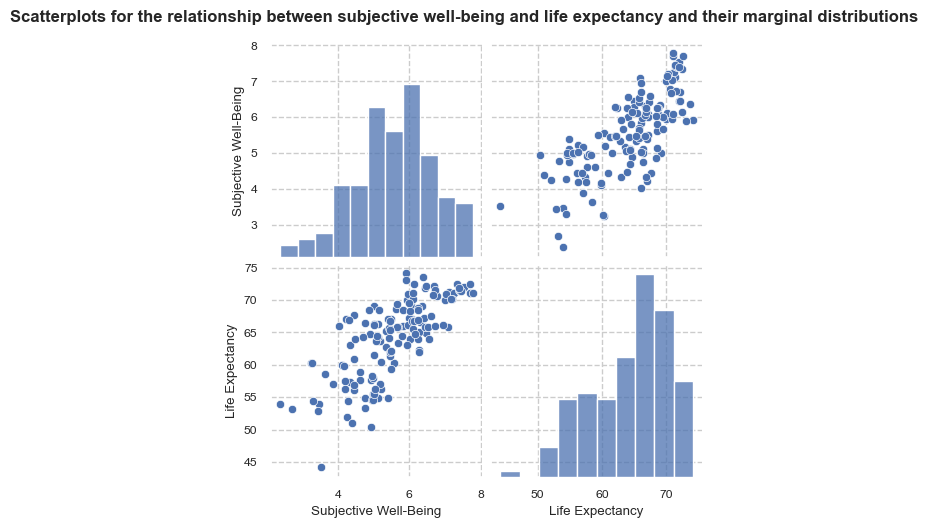

In [43]:
# display scatterplots for the relationship between SWB and life expectancy and show the marginal distribution of both variables
pp = sns.pairplot(df_19[["Subjective Well-Being", "Life Expectancy"]])
pp.fig.suptitle("Scatterplots for the relationship between subjective well-being and life expectancy and their marginal distributions", y=1.04, size=12, fontweight="bold")
plt.show()

Observations
* The scatter plots indicate a linear relationship between SWB and life expectancy. 
* The marginal distribution of life expectancy looks left-skewed, while the marginal distribution of SWB shows less deviations from the normal distribution. 

In [44]:
# define a function to add a column indicating whether a row is an outlier or not
def flag_outliers(data, outliers, directions=None):
    flag_out = []
    flag_dir = []
    for index in range(data.shape[0]):
        if index in outliers:
            flag_out.append(1)
            if directions is not None:
                flag_dir.append(directions[0])
                del directions[0]
        else:
            flag_out.append(0)
            flag_dir.append(0)
    return flag_out, flag_dir

# define a function to identify univariate outliers in a variable
def identify_and_flag_MAD_outliers(data, var, to_show, continent=None):
    # calculate the median absolute deviation from the median (MAD)
    mad = sp.stats.median_abs_deviation(data[var], scale="normal", nan_policy='omit')  # use the MAD to detect univariate outliers (see Leys et al., 2013, p. 766)

    # calculate the cutoff values - a cutoff of 3 was recommended in Leys et al. (2019, pp. 8-9)
    median = data[var].median()
    lower = median - 3*mad
    higher = median + 3*mad
    
    # get indexes of outliers
    outlier = []
    direction = []
    for index, value in enumerate(data[var]):
        if value < lower: 
            outlier.append(index)
            direction.append("lower")
        elif value > higher:
            outlier.append(index)
            direction.append("higher")
        else:
            continue

    if len(outlier) > 0:
        col_outlier = f"{var} Outlier" if continent is None else f"{var} Outlier {continent}"
        col_outlier_direction = f"{var} Outlier Direction" 
        df_out = data.copy()
        df_out[col_outlier], df_out[col_outlier_direction] = flag_outliers(df_out, outlier, direction)
        df_out = df_out.loc[df_out[col_outlier] == 1][to_show + [var] + [col_outlier_direction]]
        return df_out
    else:
        return None

# determine univariate outliers for SWB and life expectancy across continents based on the MAD
df_out_ll = identify_and_flag_MAD_outliers(df_19, "Subjective Well-Being", ["Country name", "Continent"])
df_out_hex = identify_and_flag_MAD_outliers(df_19, "Life Expectancy", ["Country name", "Continent"])

if df_out_ll is not None:
    display(df_out_ll) 
if df_out_hex is not None:
    display(df_out_hex)

Country name Continent  Subjective Well-Being  \
11  Afghanistan      Asia                  2.375   

   Subjective Well-Being Outlier Direction  
11                                   lower

Country name Continent  Life Expectancy Life Expectancy Outlier Direction
1057      Lesotho    Africa           44.200                             lower

Observations
* Afghanistan has an unusually low level of subjective well-being.
* Lesotho has an unusually low life expectancy.
* More than one univariate outlier per variable was not identified using the MAD method. 

Country name Continent  Subjective Well-Being  Life Expectancy
1057      Lesotho    Africa                  3.512           44.200

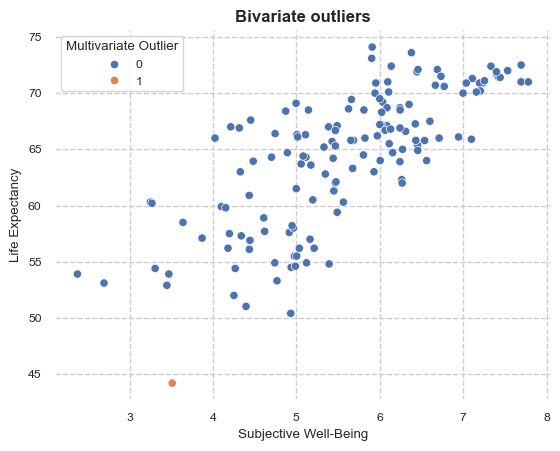

In [45]:
# determine multivariate outliers using the robust Mahalanobis method described in Horsch (2020, section "robust Mahalanobis distance")
def robust_mahalanobis_method(data, var, continent=None):  
    rel_data = data[var].copy()
    X = rel_data.to_numpy()
    cov = MinCovDet(random_state=0).fit(X)  # calculate the minimum covariance determinant 
    mcd = cov.covariance_  # robust covariance metric
    robust_mean = cov.location_  # robust mean
    inv_covmat = sp.linalg.inv(mcd)  # inverse covariance metric
    
    # robust Mahalanobis Distance
    x_minus_mu = rel_data - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    # flag as outlier
    outlier = []
    C = np.sqrt(sp.stats.chi2.ppf((1-0.001), df=rel_data.shape[1]))  # degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue

    # identify the outlying data record
    df_out = data.copy()
    col_outlier = f"Multivariate Outlier" if continent is None else f"Multivariate Outlier {continent}"
    df_out[col_outlier], _ = flag_outliers(df_out, outlier)
    display(df_out.loc[df_out[col_outlier] == 1][["Country name", "Continent"] + var])

    # visually display the outlying data record
    ax = sns.scatterplot(x=var[0], y=var[1], hue=col_outlier, data=df_out)
    title = "Bivariate outliers"
    if continent is not None:
        title += f" for {continent}"
    plt.title(title, size=12, fontweight="bold")
    plt.show()

# determine bivariate outliers for SWB and life expectancy across continents based on the robust Mahalanobis method
robust_mahalanobis_method(df_19, ['Subjective Well-Being', 'Life Expectancy'])

Observations
* There is one bivariate outlier: Lesotho. 
* Lesotho has also been identified as a univariate outlier.

In [46]:
# calculate the three correlation coefficients
def calculate_corr_coeff(data, var_1, var_2):
    # calculate Pearson's correlation coefficient
    pearson = pg.corr(data[var_1], data[var_2])

    # calculate the percentage bend correlation coefficient
    percbend = pg.corr(data[var_1], data[var_2], method="percbend")

    # calculate the skipped Spearman correlation coefficient
    skipped = pg.corr(data[var_1], data[var_2], method="skipped")

    # merge all three datasets
    return pd.concat([pearson, percbend, skipped])

corr_coeffs_glob = calculate_corr_coeff(df_19, "Subjective Well-Being", "Life Expectancy")
display(corr_coeffs_glob)

n     r         CI95%  p-val       BF10  power  outliers
pearson   144 0.747  [0.66, 0.81]  0.000  6.702e+23  1.000       NaN
percbend  144 0.758  [0.68, 0.82]  0.000        NaN  1.000       NaN
skipped   144 0.744  [0.66, 0.81]  0.000        NaN  1.000     1.000

Observations
* All three correlation coefficients point in the same direction: they indicate a positive (and statistically significant) correlation between SWB and life expectancy. The higher the life expectancy in a country, the higher its SWB. 
* Although the percentage bend correlation coefficient is not directly comparable with the other correlation coefficients (Pernet et al., 2013, p. 1), all three coefficients indicate a strong correlation between the variables (Cohen, 1988, p. 80). 

### Correlation Between Subjective Well-Being and Life Expectancy by Continent

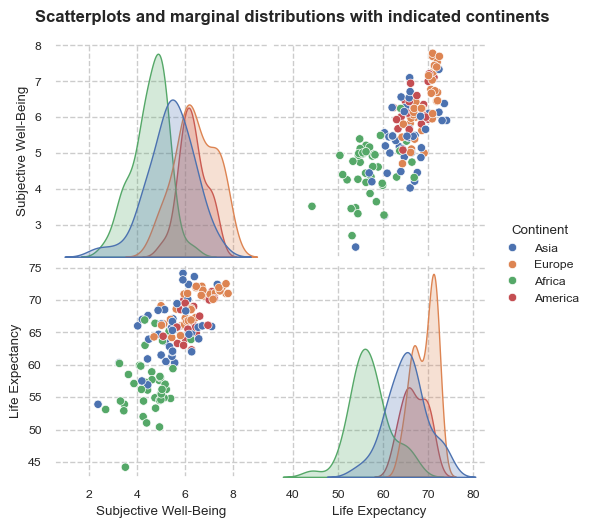

In [47]:
# visualize the continents using different colors in the scatter plot
df_19_corr = df_19[["Continent", "Subjective Well-Being", "Life Expectancy"]].copy()
pp = sns.pairplot(df_19_corr, hue="Continent")
pp.fig.suptitle("Scatterplots and marginal distributions with indicated continents", y=1.04, size=12, fontweight="bold")
plt.show()

Observations
* In Europe and America, the distribution of life expectancy looks bimodal and therefore not normal. 
* The distribution of life expectancy for Africa and Asia resembles a normal distribution, except that there is a slight bulge on the right-hand side of the distribution.
* The continents are not randomly distributed across the scatter plot. Europe and America tend to be in the top right quadrant, while Africa tends to be in the bottom left quadrant. No clear trend can be identified for Asia. 

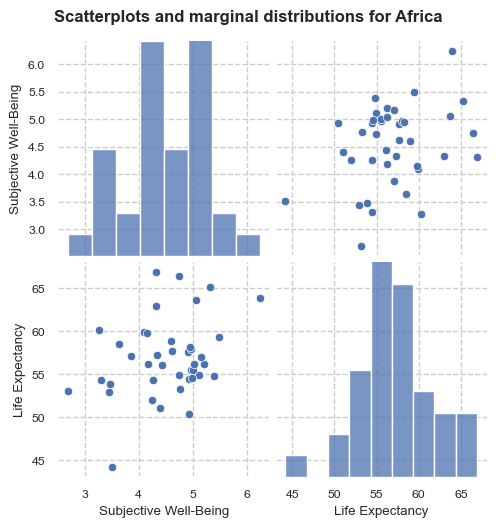

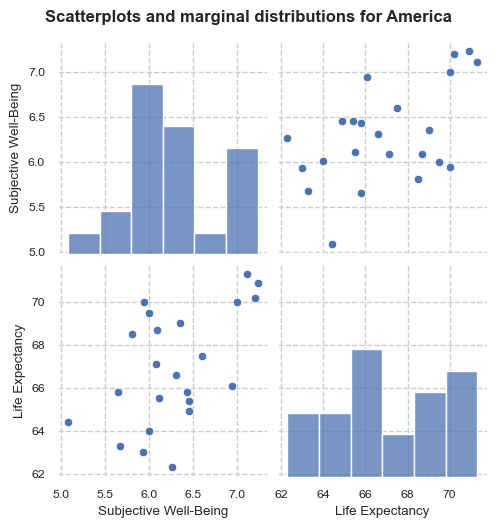

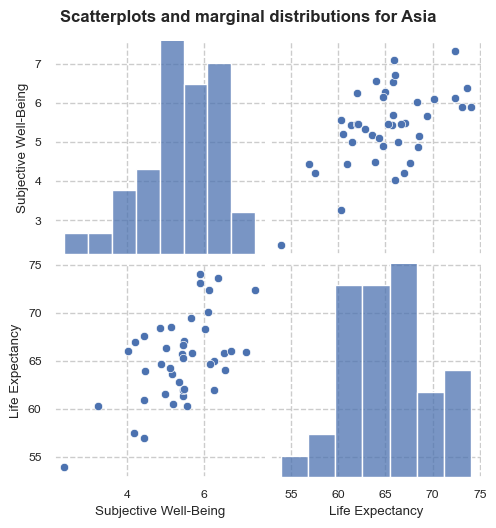

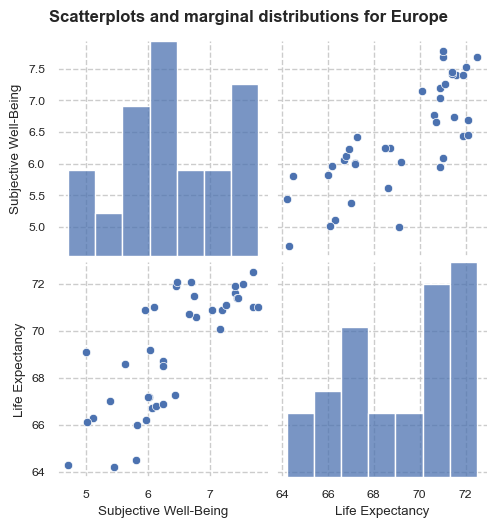

In [48]:
# show scatter plots and marginal distributions for each continent individually
for continent in continents:
    df_cont = df_19_corr.loc[df_19_corr["Continent"] == continent]
    g = sns.pairplot(df_cont[["Subjective Well-Being", "Life Expectancy"]])
    g.fig.suptitle(f"Scatterplots and marginal distributions for {continent}", y=1.04, size=12, fontweight="bold")
    plt.ylim(0, 10)
    plt.show()

Observations
* As can already be seen from the kernel density estimate plots, the marginal distribution of life expectancy in America and Europe deviates more strongly from the normal distribution than in Asia and Africa. 
* In all continents, the scatter plots indicate a linear relationship between SWB and life expectancy. 
* This relationship appears to be stronger for Europe and Asia than for Africa and America, as the points for Europe and Asia scatter closer around a straight line than for Africa and America. 

In [49]:
# determine univariate outliers for SWB and life expectancy for each continent
for continent in continents:
    df_cont = df_19.loc[df_19["Continent"] == continent].copy()
    df_cont_out_ll = identify_and_flag_MAD_outliers(df_cont, "Subjective Well-Being", ["Country name", "Continent"], continent=continent)
    df_cont_out_hex = identify_and_flag_MAD_outliers(df_cont, "Life Expectancy", ["Country name", "Continent"], continent=continent)
    if df_cont_out_ll is not None:
        display(df_cont_out_ll) 
    if df_cont_out_hex is not None:
        display(df_cont_out_hex)

Country name Continent  Subjective Well-Being  \
2086     Zimbabwe    Africa                  2.694   

     Subjective Well-Being Outlier Direction  
2086                                   lower

Country name Continent  Life Expectancy Life Expectancy Outlier Direction
34        Algeria    Africa           66.400                            higher
1057      Lesotho    Africa           44.200                             lower
1876      Tunisia    Africa           66.900                            higher

Country name Continent  Subjective Well-Being  \
11  Afghanistan      Asia                  2.375   

   Subjective Well-Being Outlier Direction  
11                                   lower

Observations
* Neither America nor Europe show identifiable univariate outliers in the two variables using the MAD method.
* An outlier was identified in SWB for Asia. This is the same data point that was already identified as an outlier in the overall dataset.
* For Africa, a total of three univariate outliers were identified - one in SWB and three in life expectancy. Zimbabwe has unusually low SWB. Algeria and Tunisia have an unusually high life expectancy for Africa, while it is unusually low in Lesotho. 

Country name Continent  Subjective Well-Being  Life Expectancy
1057      Lesotho    Africa                  3.512           44.200
1184    Mauritius    Africa                  6.241           63.900

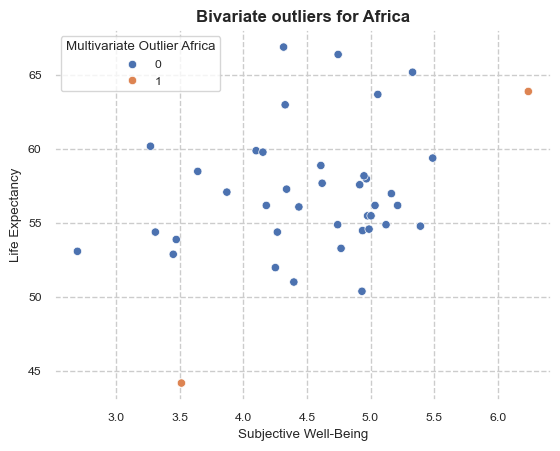

Country name Continent  Subjective Well-Being  Life Expectancy
84    Australia   America                  7.234           70.900

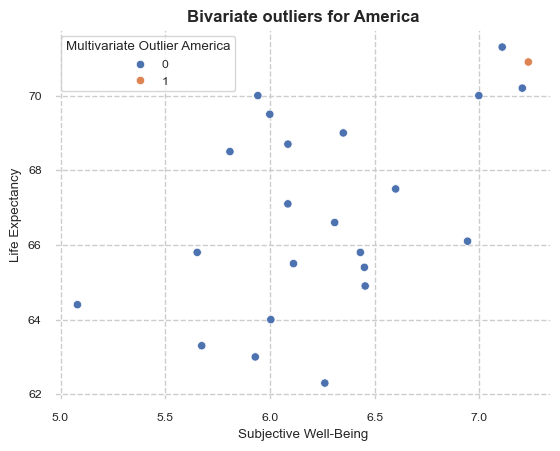

Country name Continent  Subjective Well-Being  Life Expectancy
11  Afghanistan      Asia                  2.375           53.900

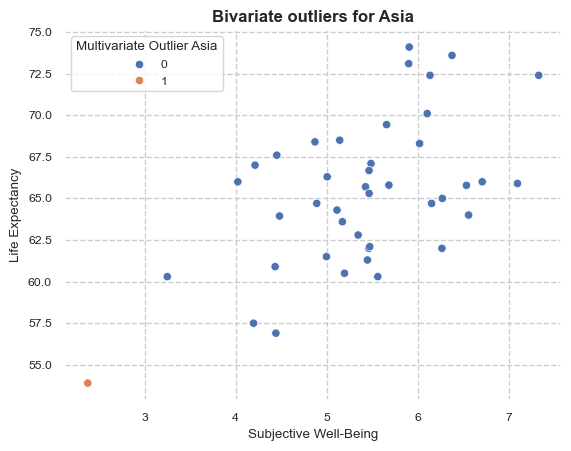

Country name Continent  Subjective Well-Being  Life Expectancy
24       Albania    Europe                  4.995           69.100
692       Greece    Europe                  5.952           70.900

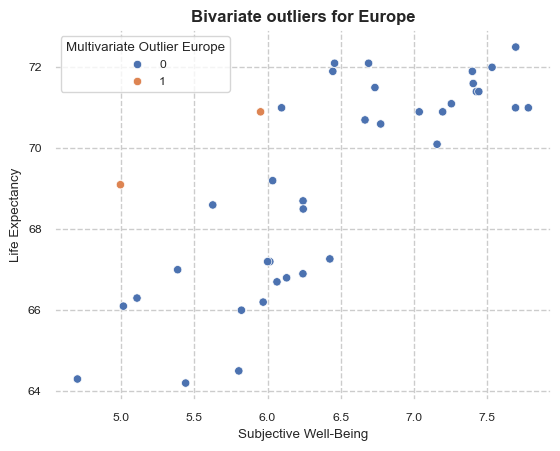

In [50]:
# determine bivariate outliers for SWB and life expectancy for each continent based on the robust Mahalanobis method
for continent in continents: 
    df_cont = df_19.loc[df_19["Continent"] == continent].copy()
    robust_mahalanobis_method(df_cont, ['Subjective Well-Being', 'Life Expectancy'], continent)

Observations
* Each continent has at least one multivariate outlier. 
* Europe and Africa have two multivariate outliers, while Asia and America have one. 
* In the scatter plot for America, the identified multivariate outlier does not really look like one.

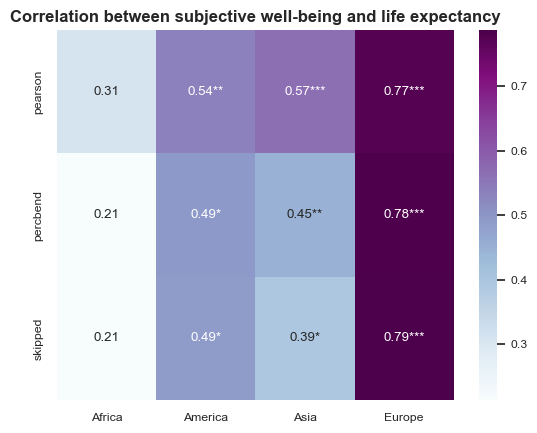

In [51]:
# define a function to convert p-values into asterisks
def convert_p_val_to_asterisk(p_val):
    if p_val <= 0.001:
        return "***"
    elif p_val <= 0.01:
        return "**"
    elif p_val <= 0.05:
        return "*"
    else:
        return ""

# calculate the three correlation coefficients
corrs = {}
annot_asterisks = []
for continent in continents:
    # calculate the correlation coefficients
    df_cont = df_19.loc[df_19["Continent"] == continent]
    corr_coeffs = calculate_corr_coeff(df_cont, "Subjective Well-Being", "Life Expectancy")
    corrs[continent] = corr_coeffs["r"].tolist()

    # extract the p-values and transform them into the asterisk notation
    p_vals = corr_coeffs["p-val"].tolist()
    asterisks = [convert_p_val_to_asterisk(p_val) for p_val in p_vals]
    annot = [str(round(corr, 2)) + asterisks[n] for n, corr in enumerate(corrs[continent])]
    annot_asterisks.append(annot)

# create a dataframe with the three correlation coefficients per continent 
df_corr = pd.DataFrame(corrs, index=["pearson", "percbend", "skipped"])

# convert the annotation into a numpy array and transpose the array so that it can be used as an annotation in the seaborn heatmap
annot_array = np.array(annot_asterisks).transpose()

# display the correlation coefficients including the significance information as a heatmap
sns.heatmap(df_corr, annot=annot_array, cmap="BuPu", fmt="")
plt.title("Correlation between subjective well-being and life expectancy", size=12, fontweight="bold")
plt.show()

Observations
* Pearson's r is higher than the robust alternatives for all continents except Europe.
* The correlation between SWB and life expectancy is strongest in Europe.
* For all continents, all three correlation coefficients indicate that the correlation between SWB and life expectancy is significant. Only in Africa is the correlation not significant. 

## Further Visual Exploration

In the following, further visualizations of the data are created in order to uncover other interesting aspects and to examine interesting aspects that have already been discovered in more detail. For one, choropleth maps of the data are created and, for another, the correlation between SWB and life expectancy in Europe is examined more closely than before. The focus is on Europe because the correlation was particularly strong there. 

### Choropleth Maps

In [52]:
# load geojson file (DataHub, 2018)
world_geo = gpd.read_file("countries.geojson")
world_geo.head()

ADMIN ISO_A3                                           geometry
0        Aruba    ABW  POLYGON ((-69.99694 12.57758, -69.93639 12.531...
1  Afghanistan    AFG  POLYGON ((71.04980 38.40866, 71.05714 38.40903...
2       Angola    AGO  MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...
3     Anguilla    AIA  MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ...
4      Albania    ALB  POLYGON ((19.74777 42.57890, 19.74601 42.57993...

In [53]:
# define a function that identifies differently named countries in the world_geo dataframe and in the SWB dataset
def country_differences(geo_file, data, colname_geo, colname_data):
    not_in_geo = []
    not_in_data = []
    
    # check whether there are any countries in the SWB dataset that are not in the geo_file
    for country in data[colname_data]:
        if country not in geo_file[colname_geo].tolist():
            not_in_geo.append(country)
    
    # check whether there are any countries in the geo_file that are not in the SWB dataset
    for country in geo_file[colname_geo]:
        if country not in data[colname_data].tolist():
            not_in_data.append(country)

    return not_in_geo, not_in_data

# check whether the country names in the world_geo dataframe are different from those in the SWB dataset
df_geo = df_19.copy()
not_in_geo_all, not_in_data_all = country_differences(world_geo, df_geo, "ADMIN", "Country name")

print("\nCountries from the SWB dataset not found in the geo file:", not_in_geo_all)
print("\nCountries from the geo file not found in the SWB dataset:", not_in_data_all) 


Countries from the SWB dataset not found in the geo file: ['Congo (Brazzaville)', 'Eswatini', 'Hong Kong S.A.R. of China', 'North Cyprus', 'North Macedonia', 'Palestinian Territories', 'Serbia', 'Taiwan Province of China', 'Tanzania', 'United States']

Countries from the geo file not found in the SWB dataset: ['Aruba', 'Angola', 'Anguilla', 'Aland', 'Andorra', 'American Samoa', 'Antarctica', 'Ashmore and Cartier Islands', 'French Southern and Antarctic Lands', 'Antigua and Barbuda', 'Burundi', 'The Bahamas', 'Bajo Nuevo Bank (Petrel Is.)', 'Saint Barthelemy', 'Belize', 'Bermuda', 'Barbados', 'Brunei', 'Bhutan', 'Central African Republic', 'Clipperton Island', 'Cyprus No Mans Area', 'Democratic Republic of the Congo', 'Republic of Congo', 'Cook Islands', 'Cape Verde', 'Coral Sea Islands', 'Cuba', 'Curaçao', 'Cayman Islands', 'Northern Cyprus', 'Czech Republic', 'Djibouti', 'Dominica', 'Eritrea', 'Dhekelia Sovereign Base Area', 'Fiji', 'Falkland Islands', 'Faroe Islands', 'Federated Sta

Observations
* Some countries are named differently in the two datasets. 
* For some countries, there is no data entry in the SWB dataset.

In [54]:
# match the country names in the SWB dataset to the country names in the world_geo dataframe
to_replace = ["Congo (Brazzaville)", "Eswatini", "Hong Kong S.A.R. of China", "North Cyprus", "North Macedonia", "Palestinian Territories", 
              "Serbia", "Taiwan Province of China", "Tanzania", "United States"]
replace_with = ["Republic of Congo", "Swaziland", "Hong Kong S.A.R.", "Northern Cyprus", "Macedonia", "Palestine", "Republic of Serbia", 
                "Taiwan", "United Republic of Tanzania", "United States of America"]

df_geo["Country name"].replace(to_replace, replace_with, inplace=True)

# check whether the countries have been successfully renamed
not_in_geo_all, _ = country_differences(world_geo, df_geo, "ADMIN", "Country name")
print("Countries from the SWB dataset not found in the geo file:", not_in_geo_all)

Countries from the SWB dataset not found in the geo file: []


Observation
* There are no longer any countries in the SWB dataset that are not also present in the world_geo DataFrame.

In [55]:
# merge the two datasets to be able to create a choropleth map
df_world = pd.merge(
        left=world_geo,
        right=df_geo,
        left_on="ADMIN",
        right_on="Country name",
        how="left"
    )

# look at the merged dataset
df_world.head()

ADMIN ISO_A3                                           geometry  \
0        Aruba    ABW  POLYGON ((-69.99694 12.57758, -69.93639 12.531...   
1  Afghanistan    AFG  POLYGON ((71.04980 38.40866, 71.05714 38.40903...   
2       Angola    AGO  MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...   
3     Anguilla    AIA  MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ...   
4      Albania    ALB  POLYGON ((19.74777 42.57890, 19.74601 42.57993...   

  Country name Continent           Region Country code  Subjective Well-Being  \
0          NaN       NaN              NaN          NaN                    NaN   
1  Afghanistan      Asia    Southern Asia           AF                  2.375   
2          NaN       NaN              NaN          NaN                    NaN   
3          NaN       NaN              NaN          NaN                    NaN   
4      Albania    Europe  Southern Europe           AL                  4.995   

   Life Expectancy  
0              NaN  
1           53.900  
2              NaN  
3              NaN  
4           69.100

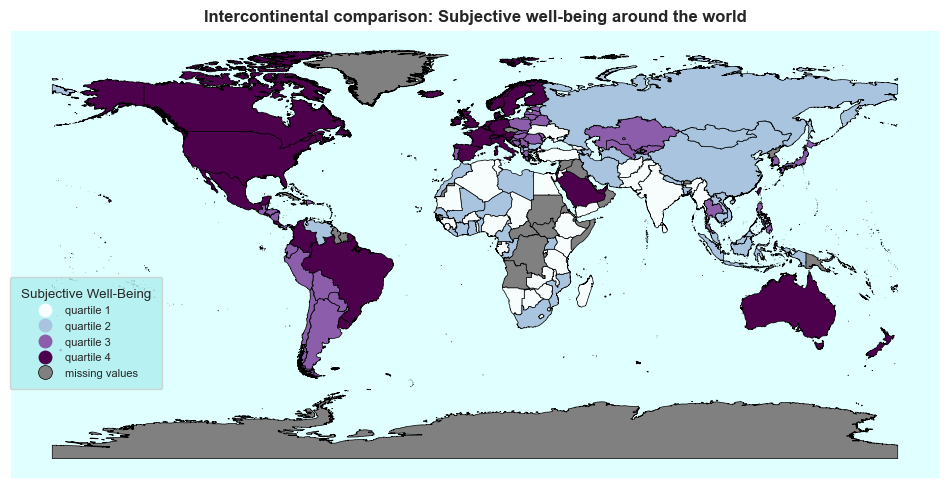

In [56]:
# define a function that calculates the quartiles of a pandas series
def calculate_quartiles(series):
    return pd.qcut(series, 4, labels=["quartile 1", "quartile 2", "quartile 3", "quartile 4"])

# add SWB quartiles to the dataset
df_world["swb_quartile"] = calculate_quartiles(df_world["Subjective Well-Being"])

# define a function to create a choropleth map visualizing the values of a column
def create_choropleth(data, continent, col, title):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    data.plot(
        ax=ax,
        column=col, 
        edgecolor="black",
        linewidth=0.5,
        legend=True,
        cmap="BuPu",
        legend_kwds={"loc": (10, 0),
                     "bbox_to_anchor":(0, .2),
                     "title_fontsize": "medium",
                     "fontsize": "small",
                     "title": "Subjective Well-Being",
                     "borderpad": 1,
                     "facecolor": "paleturquoise"},
        missing_kwds={"color": "grey",
                      "label": "missing values"}
    )
    
    # hide x and y axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # add a title
    ax.set_title(title, size=12, weight="bold") 

    # change background color
    ax.set_facecolor("lightcyan")

# create a choropleth map showing the quartiles of the SWB
create_choropleth(df_world, "World", "swb_quartile", "Intercontinental comparison: Subjective well-being around the world")

Observations
* Intercontinental differences in the SWB are clearly visible: America, Oceania and Europe tend to have high SWB, while Asia and Africa tend to have low SWB. 
* Data is missing for some countries in Central Africa. 
* Due to the large intercontinental differences, intracontinental differences are not as clear (e.g. most countries in Europe are purple or light purple).

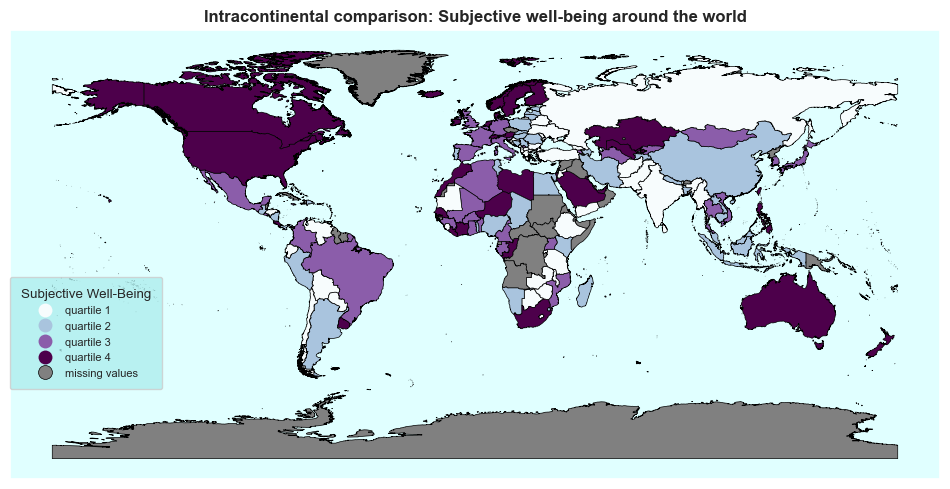

In [57]:
# calculate the SWB quartiles for each continent individually
df_world["swb_quartile_per_cont"] = df_world.groupby("Continent")["Subjective Well-Being"].transform(calculate_quartiles)  
create_choropleth(df_world, "World", "swb_quartile_per_cont", "Intracontinental comparison: Subjective well-being around the world")

Observations
* Intercontinental differences are no longer visible. Instead, intracontinental differences are shown.
* In three continents (Europe, America, Asia), the North is generally happier than the South. 
* In Africa, the northwest tends to be happier than some countries in East Africa. 
* In Asia, the southwest tends to be less happy than the southeast. 
* However, there is a risk of misunderstanding this illustration. One might think that Australia has roughly the same SWB as South Africa, which is actually not true, as the first choropleth map illustrates. 

### Correlation Between Subjective Well-Being and Life Expectancy in Europe

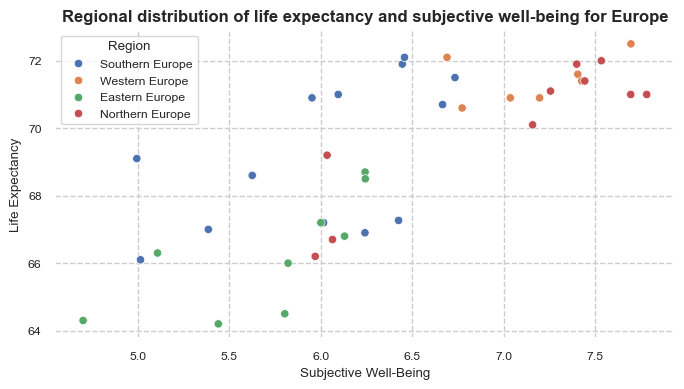

In [58]:
# examine the regional distribution of the data points in the scatterplot
df_eur = df_19[df_19["Continent"] == "Europe"].copy()
fig, ax = plt.subplots(1, figsize=(8, 4))
ax = sns.scatterplot(x="Subjective Well-Being", y="Life Expectancy", hue='Region', data=df_eur) 
plt.title("Regional distribution of life expectancy and subjective well-being for Europe", size=12, fontweight="bold")
plt.show()

Observations
* Eastern and Southern European countries are characterized by rather low life expectancy and low SWB in a regional comparison, whereby the life expectancy of Eastern Europe is usually lower than that of Southern Europe.
* Western and Northern European countries, on the other hand, are characterized by rather high life expectancy and high SWB in a regional comparison. Three Northern European countries stand out, however, as they have lower life expectancies and lower levels of SWB than the other Northern European countries.   

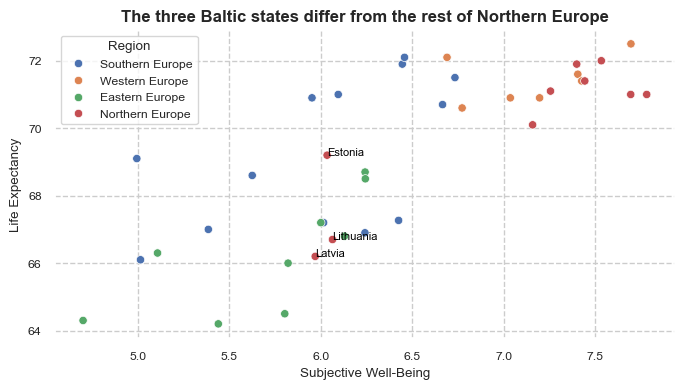

In [59]:
# identify the three Northern European countries that stand out - using an illustration similar to the one in Schwabish (2021, p. 232)
outlying_countries = df_eur.loc[(df_eur["Subjective Well-Being"] < 6.5) & (df_eur["Life Expectancy"] < 70) & (df_eur["Region"] == "Northern Europe")]["Country name"].tolist()
df_eur["outlying_ne"] = [country if country in outlying_countries else "" for country in df_eur["Country name"]]

# plot scatter plot
fig, ax = plt.subplots(1, figsize=(8, 4))
ax = sns.scatterplot(x="Subjective Well-Being", y="Life Expectancy", hue='Region', data=df_eur)

# annotate the points in the scatter plot with the respective country names
for line in range(df_eur.shape[0]):
    plt.text(
        df_eur["Subjective Well-Being"].iloc[line], 
        df_eur["Life Expectancy"].iloc[line], 
        df_eur["outlying_ne"].iloc[line], 
        horizontalalignment='left', 
        size='small', 
        color='black', 
    )

plt.title("The three Baltic states differ from the rest of Northern Europe", size=12, fontweight="bold")
plt.show()

Observations
* The three Northern European countries that differ from the other Northern European countries are the three Baltic states of Estonia, Latvia and Lithuania. 
* Based on the visualization, the three Baltic states fit more into Eastern Europe than Northern Europe.   

## Create Figures to Show in the Written Assignment

The illustrations used in the corresponding Written Assignment are generated below. The design principles described in Schawbish (2021, chapter 2) are observed.

### Distribution of Subjective Well-Being

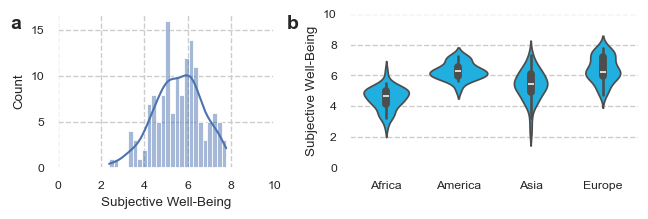

In [60]:
# create a figure showing the global distribution of SWB and violin plots of the intercontinental distribution of SWB
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 2), gridspec_kw={"width_ratios": [1.5, 2]})
plt.subplots_adjust(wspace=0.3) 

# show the global distribution of SWB
sns.histplot(data=df_19, x="Subjective Well-Being", bins=25, kde=True, ax=ax1)
ax1.set_xlim(0, 10)

# show the intercontinal distribution of SWB
sns.violinplot(data=df_19, x="Continent", y="Subjective Well-Being", ax=ax2, color="deepskyblue", order=continents)
ax2.set_ylim(0, 10)
ax2.set(xlabel=None)

# annotate subplots with "a" and "b"
for n, ax in enumerate([ax1, ax2]):
    ax.text(-0.22, 0.9, string.ascii_lowercase[n], transform=ax.transAxes, size=14, weight="bold")

plt.savefig("Figures/1_Distribution_SWB_glob_inter.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

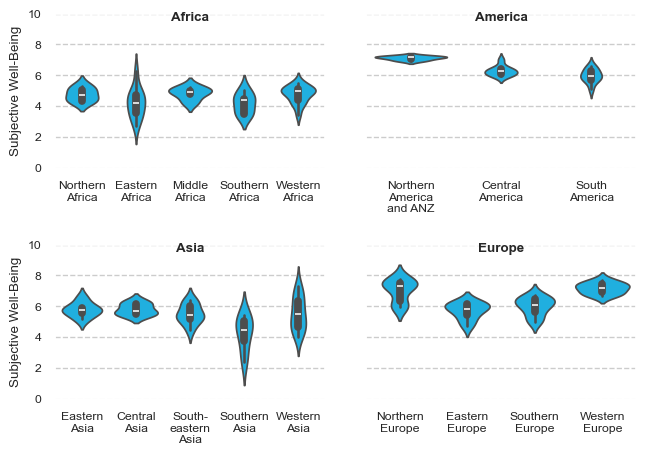

In [61]:
# specify the order of the regions within the continents 
regions_order = {
    "Africa": ["Northern Africa", "Eastern Africa", "Middle Africa", "Southern Africa", "Western Africa"],
    "America": ["Northern America and ANZ", "Central America", "South America"],
    "Asia": ["Eastern Asia", "Central Asia", "South-eastern Asia", "Southern Asia", "Western Asia"],
    "Europe": ["Northern Europe", "Eastern Europe", "Southern Europe", "Western Europe"]
}

# define a function to format the axes of a figure
def format_axes(ax, ylim, title, pad_title=-5, hide_x_label=False, hide_grid=False, remove_legend=False):
    ax.set_ylim(ylim[0], ylim[1])
    wrap_labels(ax, 10)
    ax.set_title(title, weight="bold", loc="center", pad=pad_title)
    if hide_x_label:
        ax.set(xlabel=None)
    if hide_grid:
        ax.grid(False)
        ax.get_yaxis().set_visible(False)
        ax.bar_label(ax.containers[0], label_type="center", fmt='%.2f') 
    if remove_legend:
        ax.get_legend().remove()

# create a figure showing the intracontinental distribution of SWB
fig, ax = plt.subplots(2, 2, figsize=(7.5, 5), sharey=True)
ax = ax.flatten()
plt.subplots_adjust(wspace=0.15, hspace=0.5)

for n, continent in enumerate(continents):
    df_cont = df_19[df_19["Continent"] == continent]
    sns.violinplot(data=df_cont, x="Region", y="Subjective Well-Being", ax=ax[n], color="deepskyblue", order=regions_order[continent])
    format_axes(ax[n], ylim=[0, 10], title=continent, hide_x_label=True)

plt.savefig("Figures/2_Violin_SWB_intra.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

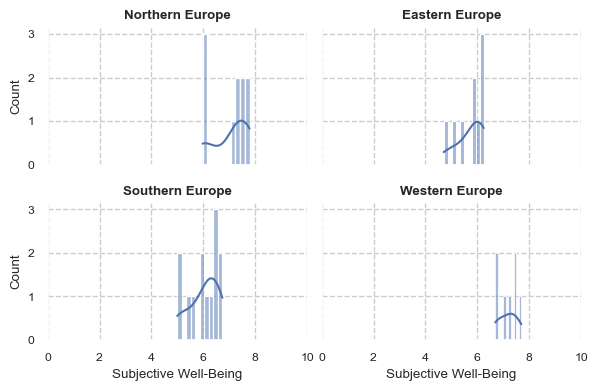

In [62]:
# create a figure that shows the distribution of SWB in European regions
df_eur_hist = df_19.loc[df_19["Continent"] == "Europe"]
g = sns.FacetGrid(df_eur_hist, col="Region", col_wrap=2, height=2, aspect=1.5, despine=True, col_order=regions_order["Europe"])
g.map(sns.histplot, "Subjective Well-Being", bins=10, kde=True)
g.set(xlim=(0, 10))
g.set_titles("{col_name}", weight="bold")
plt.savefig("Figures/3_Histo_eur.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

### Location of Subjective Well-Being

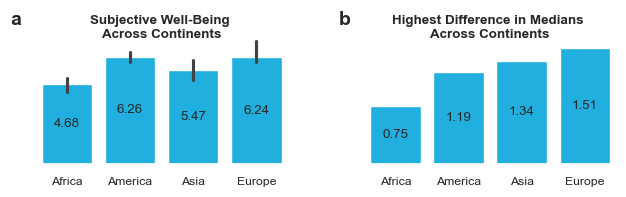

In [63]:
# create a figure that shows the medians and IQRs of SWB for different continents and that displays how large the 
# differences are in the medians of the regions within the continents 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 2))
plt.subplots_adjust(wspace=0.3)

# show the medians and IQRs of SWB for different continents
sns.barplot(data=df_19, x="Continent", y="Subjective Well-Being", estimator=np.median, errorbar=("pi", 50), color="deepskyblue",
            order=continents, ax=ax1)
ax1.set_ylim(0, 9)
ax1.set_title("Subjective Well-Being \nAcross Continents", loc="center", pad=-20, weight="bold")

# display how large the differences are in the medians of the regions within the continents
sns.barplot(data=df_diff_med.reset_index(), x="Continent", y="Highest Difference in Medians", ax=ax2, color="deepskyblue", order=continents)
ax2.set_ylim(0, 2)
ax2.set_title("Highest Difference in Medians \nAcross Continents", loc="center", pad=-20, weight="bold")

for n, ax in enumerate([ax1, ax2]):
    ax.bar_label(ax.containers[0], label_type="center", fmt='%.2f')
    ax.text(-0.1, 0.9, string.ascii_lowercase[n], transform=ax.transAxes, size=14, weight="bold")
    ax.grid(False)
    ax.get_yaxis().set_visible(False)
    ax.set(xlabel=None)

plt.savefig("Figures/4_Loc_var_SWB_inter.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

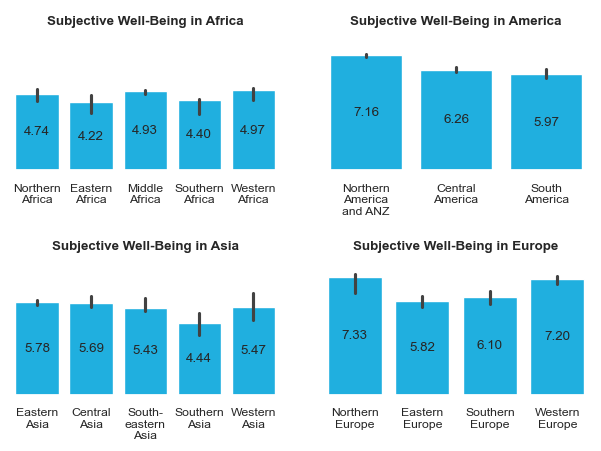

In [64]:
# create a figure showing the medians and IQRs of SWB for the regions within the continents
fig, ax = plt.subplots(2, 2, figsize=(7.5, 5))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.15, hspace=0.4)

for n, continent in enumerate(continents):
    df_cont = df_19[df_19["Continent"] == continent]
    sns.barplot(data=df_cont, x="Region", y="Subjective Well-Being", estimator=np.median, errorbar=("pi", 50), ax=ax[n], color="deepskyblue", order=regions_order[continent])
    format_axes(ax[n], ylim=[0, 10], title=f"Subjective Well-Being in {continent}", pad_title=-11, hide_x_label=True, hide_grid=True)

plt.savefig("Figures/5_Loc_var_SWB_intra.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

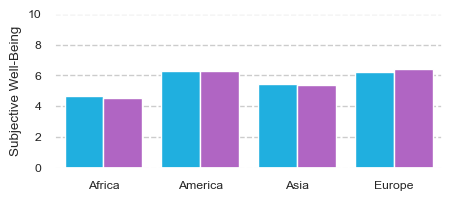

In [65]:
# define the colors for grouped bar plots
colors = ["deepskyblue", "mediumorchid"]

# create a figure showing the medians and means of SWB in the different continents
plt.figure(figsize=(5, 2))
g = sns.barplot(data=df_19_locm, x="Continent", y="Subjective Well-Being", hue="statistic", palette=colors)
g.set(xlabel=None)
g.get_legend().remove()
plt.ylim(0, 10)
plt.savefig("Figures/6_Loc_mean_med_SWB_inter.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

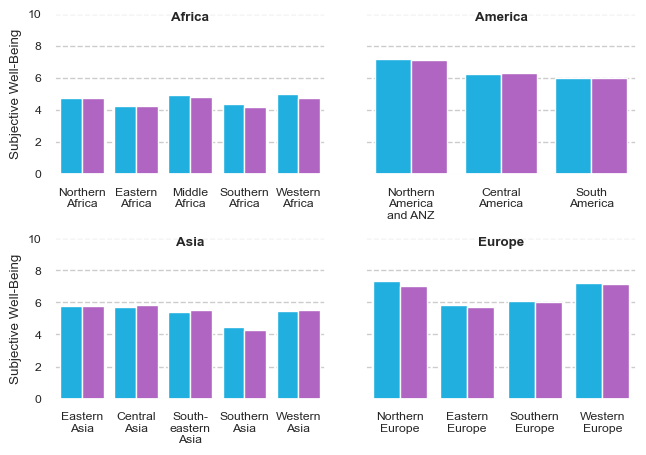

In [66]:
# create a figure showing the medians and means of SWB in the regions of the different continents
fig, ax = plt.subplots(2, 2, figsize=(7.5, 5), sharey=True)
ax = ax.flatten()
plt.subplots_adjust(wspace=0.15, hspace=0.4)

for n, continent in enumerate(continents):
    df_cont = df_19_loc_regm[df_19_loc_regm["Continent"] == continent]
    sns.barplot(data=df_cont, x="Region", y="Subjective Well-Being", hue="statistic", ax=ax[n], palette=colors, order=regions_order[continent])
    format_axes(ax[n], ylim=[0, 10], title=continent, hide_x_label=True, remove_legend=True)

plt.savefig("Figures/7_Loc_mean_med_SWB_intra.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

### Variability of Subjective Well-Being

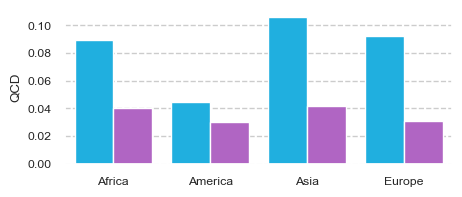

In [67]:
# create a figure that compares the QCDs of SWB and life expectancy for each continent
plt.figure(figsize=(5, 2))
ax = sns.barplot(data=df_qcd_m, x="Continent", y="QCD", hue="variable", estimator=calculate_quart_disp, errorbar=None, palette=colors, order=continents)
ax.set(xlabel=None)
ax.get_legend().remove()
plt.savefig("Figures/8_QCD_inter.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

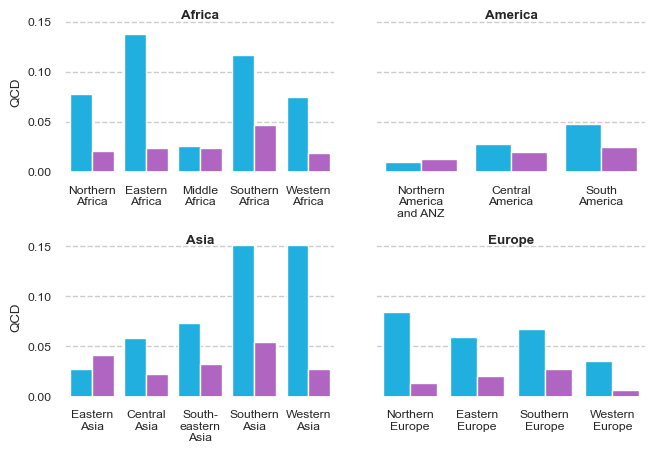

In [68]:
# create a figure that compares the QCDs of SWB and life expectancy for each region within the continents
fig, ax = plt.subplots(2, 2, figsize=(7.5, 5), sharey=True)
ax = ax.flatten()
plt.subplots_adjust(wspace=0.15, hspace=0.4)

for n, continent in enumerate(continents):
    df_cont = df_qcd_regm[df_qcd_regm["Continent"] == continent]
    sns.barplot(data=df_cont, x="Region", y="QCD", hue="variable", estimator=calculate_quart_disp, errorbar=None, ax=ax[n], palette=colors, order=regions_order[continent])
    format_axes(ax[n], ylim=[0, 0.16], title=continent, hide_x_label=True, remove_legend=True)

plt.savefig("Figures/9_QCD_intra.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

### Covariance and Correlation of Subjective Well-Being and Life Expectancy

In [69]:
# add the global correlations to the correlation heatmap
corrs["Global"] = corr_coeffs_glob["r"].tolist()
p_vals = corr_coeffs_glob["p-val"].tolist()
asterisks = [convert_p_val_to_asterisk(p_val) for p_val in p_vals]
annot = [str(round(corr, 2)) + asterisks[n] for n, corr in enumerate(corrs["Global"])]
annot_asterisks.append(annot)

# create a dataframe with the three correlation coefficients per continent 
df_corr = pd.DataFrame(corrs, index=["pearson", "percbend", "skipped"])

# convert the annotation into a numpy array and transpose the array so that it can be used as an annotation in the seaborn heatmap
annot_array = np.array(annot_asterisks).transpose()

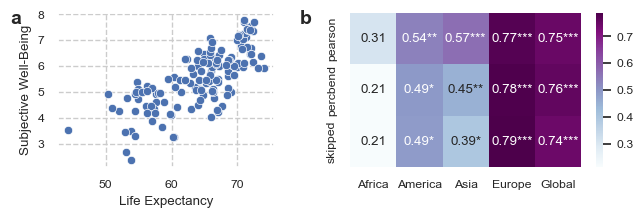

In [70]:
# create a figure that contains a scatter plot for the global relationship between SWB and life expectancy and a correlation heatmap for 
# the individual correlations within the continents and the global correlation 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 2), gridspec_kw={"width_ratios": [1.5, 2]})
plt.subplots_adjust(wspace=0.3)  

# show the scatter plot for the global relationship between SWB and life expectancy
sns.scatterplot(data=df_19, x="Life Expectancy", y="Subjective Well-Being", ax=ax1)

# show the correlation heatmap for the individual correlations within the continents and the global correlation 
sns.heatmap(df_corr, annot=annot_array, cmap="BuPu", fmt="", ax=ax2)

# annotate subplots with "a" and "b"
for n, ax in enumerate([ax1, ax2]):
    ax.text(-0.22, 0.93, string.ascii_lowercase[n], transform=ax.transAxes, size=14, weight="bold")

plt.savefig("Figures/10_Corr_glob_inter.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

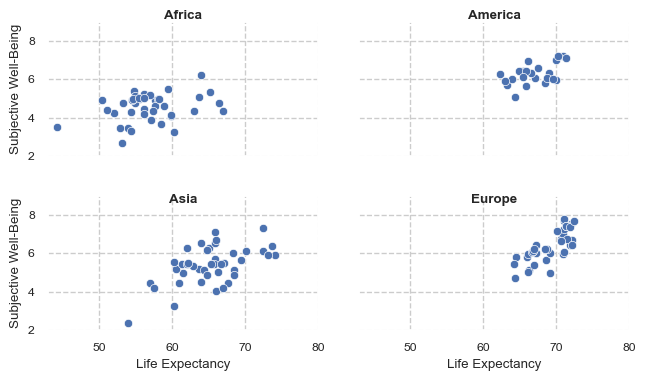

In [71]:
# create a figure that contains scatter plots for the relationship between SWB and life expectancy within the continents 
fig, ax = plt.subplots(2, 2, figsize=(7.5, 4), sharey=True, sharex=True)
ax = ax.flatten()
plt.subplots_adjust(wspace=0.15, hspace=0.3)

for n, continent in enumerate(continents):
    df_cont = df_19[df_19["Continent"] == continent]
    sns.scatterplot(data=df_cont, x="Life Expectancy", y="Subjective Well-Being", ax=ax[n])
    ax[n].set_xlim(43, 80)
    ax[n].set_ylim(2, 9)
    ax[n].set_title(continent, weight="bold", loc="center", pad=-5)

plt.savefig("Figures/11_Scatter_inter.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show() 

### Further Explorations

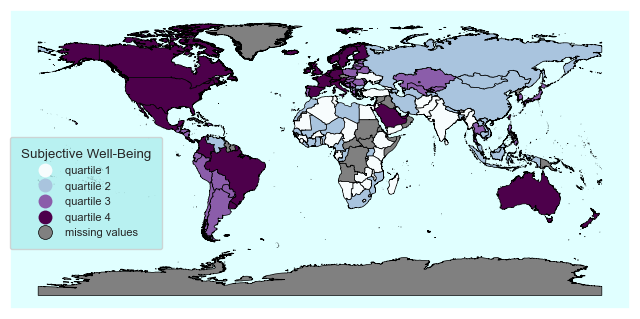

In [72]:
# define a function to create a choropleth map visualizing the values of a column
def create_choropleth_fig(data, continent, col):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    data.plot(
        ax=ax,
        column=col, 
        edgecolor="black",
        linewidth=0.5,
        legend=True,
        cmap="BuPu",
        legend_kwds={"loc": (10, 0),
                     "bbox_to_anchor":(0, .2),
                     "title_fontsize": "medium",
                     "fontsize": "small",
                     "title": "Subjective Well-Being",
                     "borderpad": 1,
                     "facecolor": "paleturquoise"},
        missing_kwds={"color": "grey",
                      "label": "missing values"}
    )
    
    # hide x and y axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # change background color
    ax.set_facecolor("lightcyan")
    
    return fig

# create a choropleth map showing the quartiles of the SWB
create_choropleth_fig(df_world, "World", "swb_quartile")
plt.savefig("Figures/12_choro_inter.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)

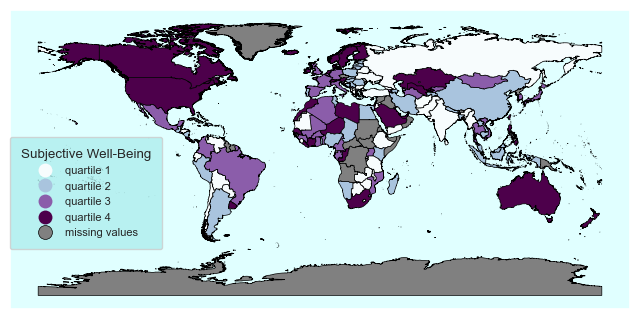

In [73]:
# create a choropleth map showing the intracontinental quartiles of the SWB
create_choropleth_fig(df_world, "World", "swb_quartile_per_cont")
plt.savefig("Figures/13_choro_intra.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)

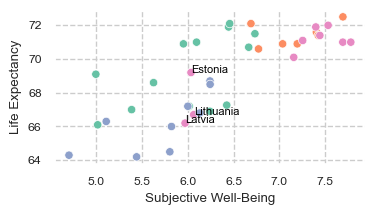

In [74]:
# create a scatterplot for Europe, annotating the three Northern European countries that do not match the rest of Northern Europe
fig, ax = plt.subplots(1, figsize=(4, 2))
color_regions = colors + ["coral", "springgreen"]
ax = sns.scatterplot(x="Subjective Well-Being", y="Life Expectancy", hue='Region', data=df_eur, palette="Set2")

# annotate the points in the scatter plot with the respective country names 
for line in range(df_eur.shape[0]):
    plt.text(
        df_eur["Subjective Well-Being"].iloc[line], 
        df_eur["Life Expectancy"].iloc[line], 
        df_eur["outlying_ne"].iloc[line], 
        horizontalalignment='left', 
        size='small', 
        color='black', 
    )

ax.get_legend().remove()
plt.savefig("Figures/14_scatter_eur_detail.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

## References

* Beretta, L., & Santaniello, A. (2016). Nearest neighbor imputation algorithms: A critical evaluation. BMC Medical Informatics and Decision Making, 16(Suppl 3), 197–208. https://doi.org/10.1186/s12911-016-0318-z
* Bruce, P. C., Bruce, A., & Gedeck, P. (2020). Practical statistics for data scientists: 50+ essential concepts using R and Python (2nd ed.). O'Reilly Media Inc.
* Cohen, J. (1988). Statistical Power Analysis for the Behavioral Sciences (2nd ed.). Lawrence Erlbaum Associates.
* DataHub. (2018). Country polygons as GeoJSON [Data set]. Retrieved December 02, 2023, from https://datahub.io/core/geo-countries#resource-countries
* Helliwell, J. F., Layard, R., Sachs, J. D., Neve, J.‑E. de, Aknin, L. B., & Wang, S. (2022a). Data for table 2.1 [Data set]. Sustainable Development Solutions Network. Retrieved December 02, 2023, from https://happiness-report.s3.amazonaws.com/2022/DataForTable2.1.xls
* Helliwell, J. F., Layard, R., Sachs, J. D., Neve, J.‑E. de, Aknin, L. B., & Wang, S. (2022b). World happiness report 2022. Sustainable Development Solutions Network. https://worldhappiness.report/ed/2022/
* Horsch, A. (2020, December 14). Detecting and treating outliers in Python — Part 2: Hands-on tutorial on multivariate outliers. https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33
* Leys, C., Delacre, M., Mora, Y. L., Lakens, D., & Ley, C. (2019). How to classify, detect, and manage univariate and multivariate outliers, with emphasis on pre-registration. International Review of Social Psychology, 32(1), Article 5, 1–10. https://doi.org/10.5334/irsp.289
* Leys, C., Ley, C., Klein, O., Bernard, P., & Licata, L. (2013). Detecting outliers: Do not use standard deviation around the mean, use absolute deviation around the median. Journal of Experimental Social Psychology, 49(4), 764–766. https://doi.org/10.1016/j.jesp.2013.03.013
* Molin, S. (2019). Hands-on data analysis with pandas: Efficiently perform data collection, wrangling, analysis, and visualization using Python. Packt Publishing.
* Pernet, C. R., Wilcox, R., & Rousselet, G. A. (2013). Robust correlation analyses: False positive and power validation using a new open source Matlab toolbox. Frontiers in Psychology, 3, Article 606. https://doi.org/10.3389/fpsyg.2012.00606
* Petrou, T. (2021, December 7). Automatically wrap graph labels in Matplotlib and Seaborn. https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
* Schwabish, J. (2021). Better data visualizations: A guide for scholars, researchers, and wonks. Columbia University Press.
* Shvili, J. (2023, February 14). Continents by number Of countries. WorldAtlas. https://www.worldatlas.com/geography/continents-by-number-of-countries.html#h_7269483389021676410468292
* United Nations Statistics Division. (2023). Methodology: Standard country or area codes for statistical use (M49). https://unstats.un.org/unsd/methodology/m49/
* Wilke, C. O. (2019). Fundamentals of data visualization: A primer on making informative and compelling figures (First edition). O'Reilly Media, Inc.